In [ ]:
!pip install praat-parselmouth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 28.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from google.colab import files
from google.colab import drive
import os

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd
import parselmouth
from parselmouth.praat import call
from scipy.io import wavfile
import glob
import os.path
from datetime import datetime
from itertools import cycle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = '/content/drive/MyDrive/Project-code-2023/EXP-wav/data/'


In [ ]:

# Create empty lists to store the audio signals and their corresponding file names
signals = []
names = []

# Loop through each file in the directory
for file in os.listdir(dir_path):
    if file.endswith('.wav'):
        # Load the audio signal and its sampling rate
        signal, sr = librosa.load(os.path.join(dir_path, file), sr=None)
        # Append the signal and file name to the lists
        signals.append(signal)
        names.append(file)

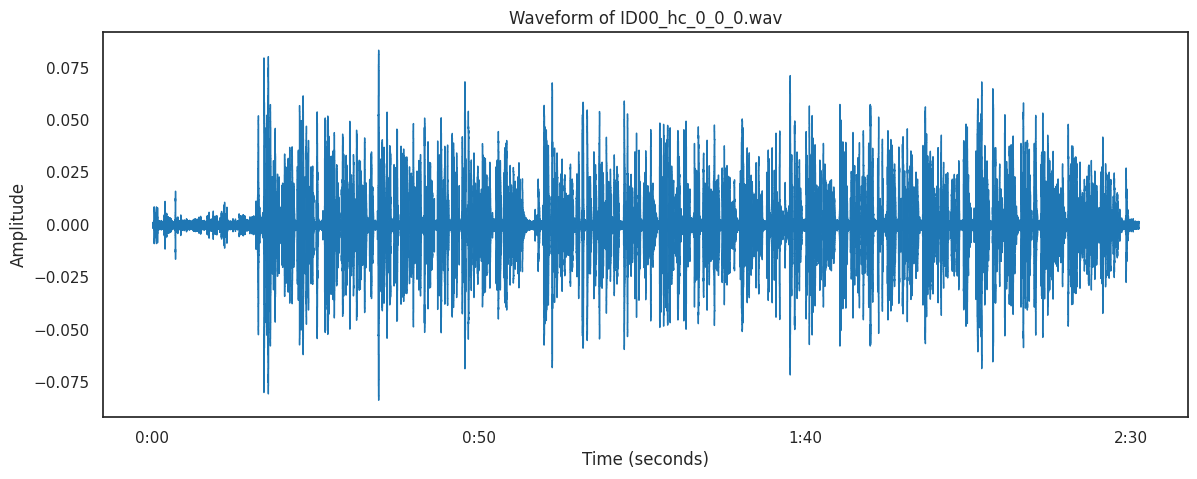

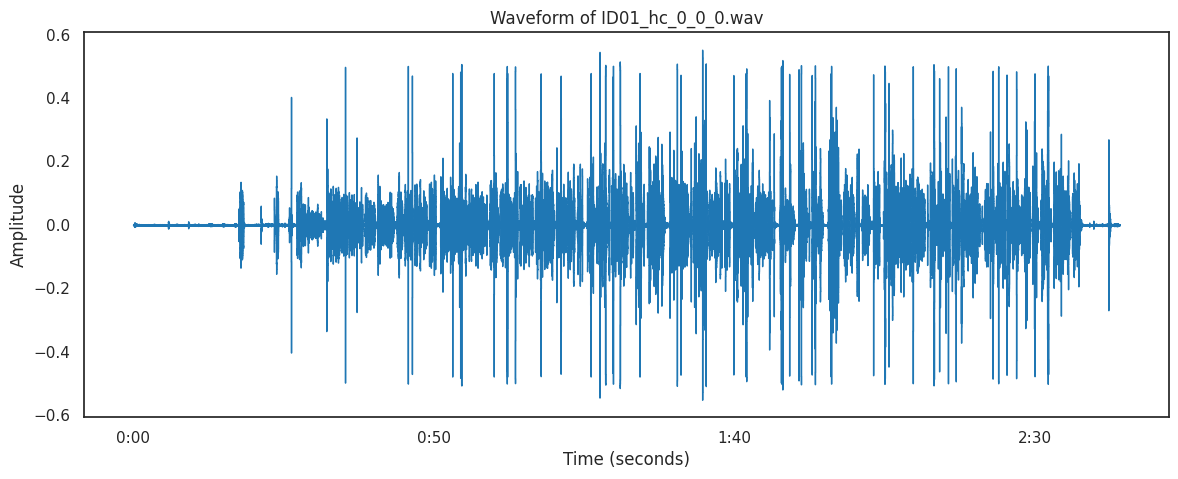

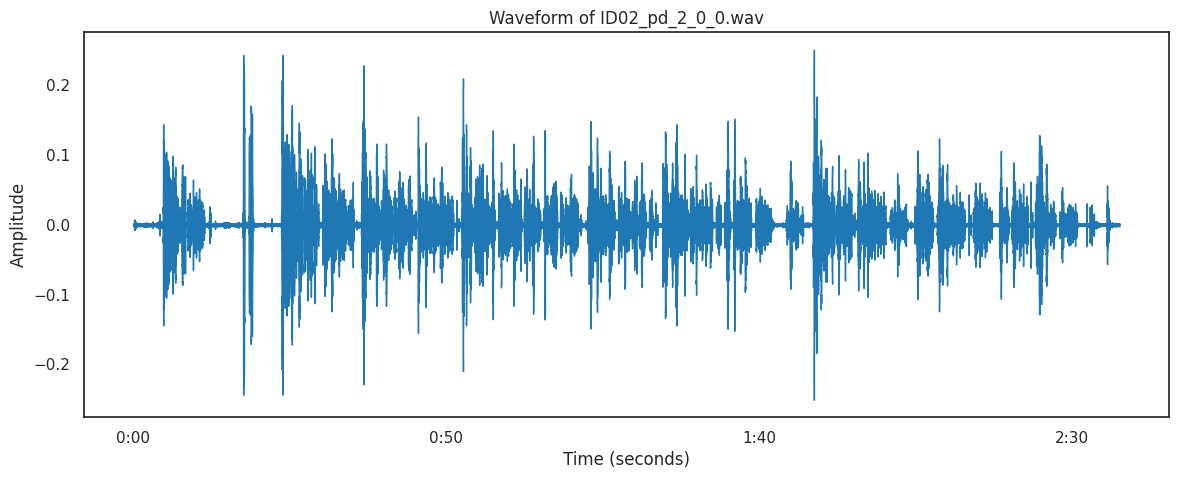

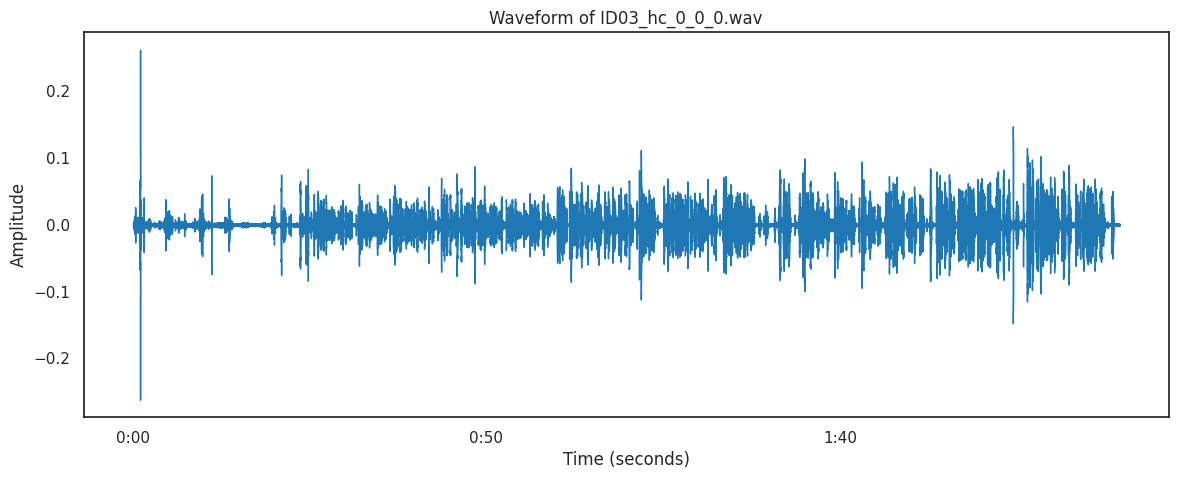

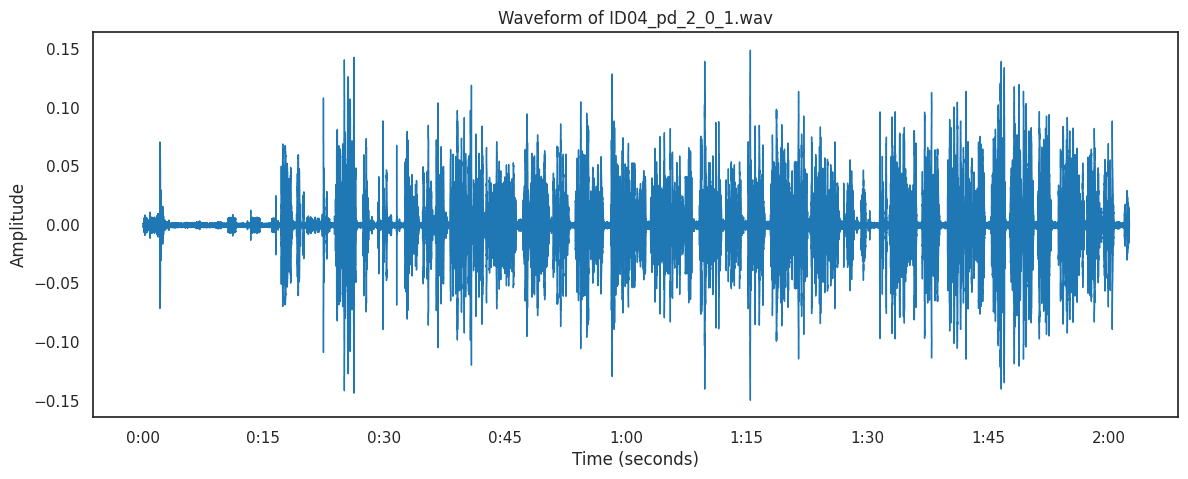

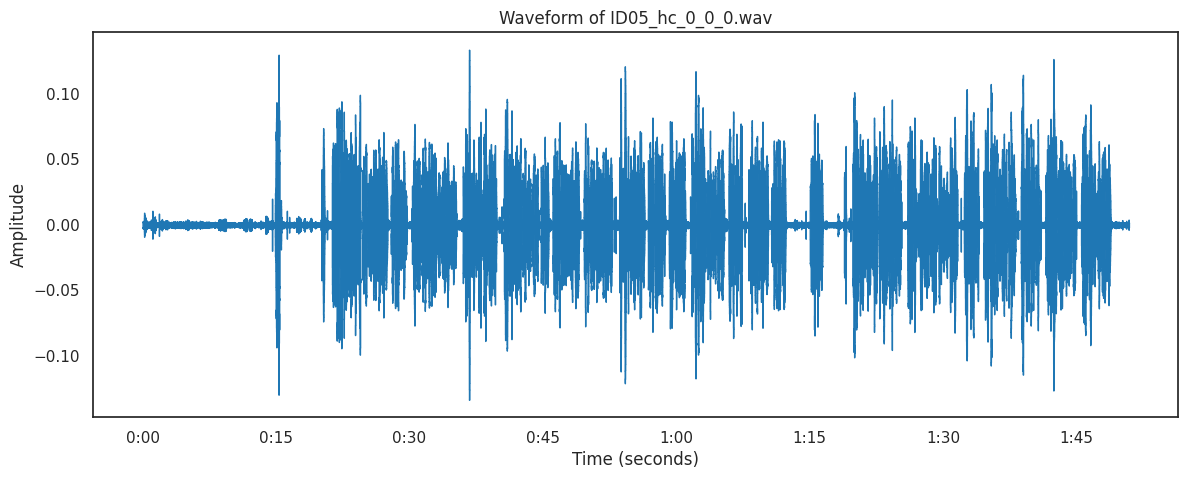

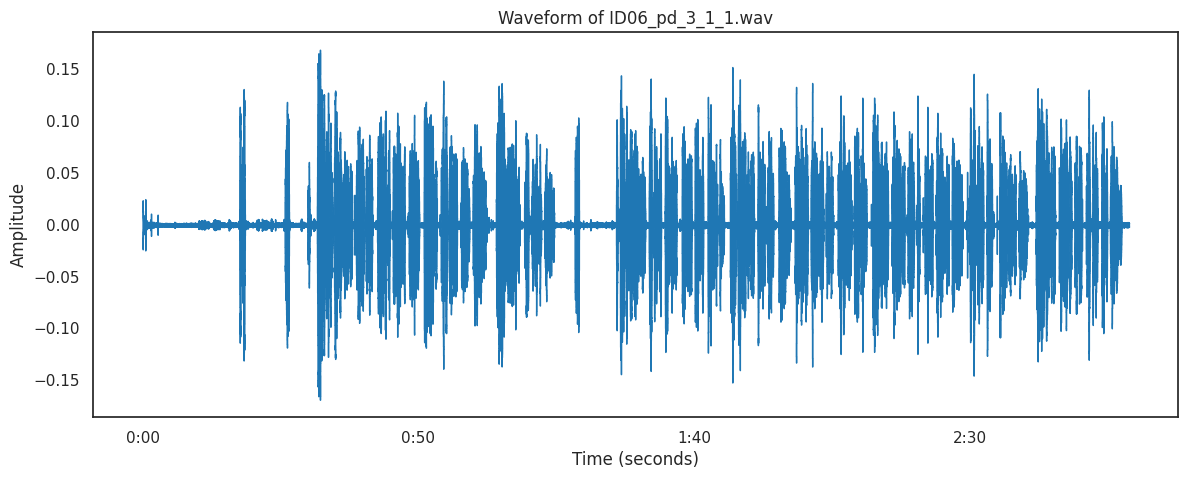

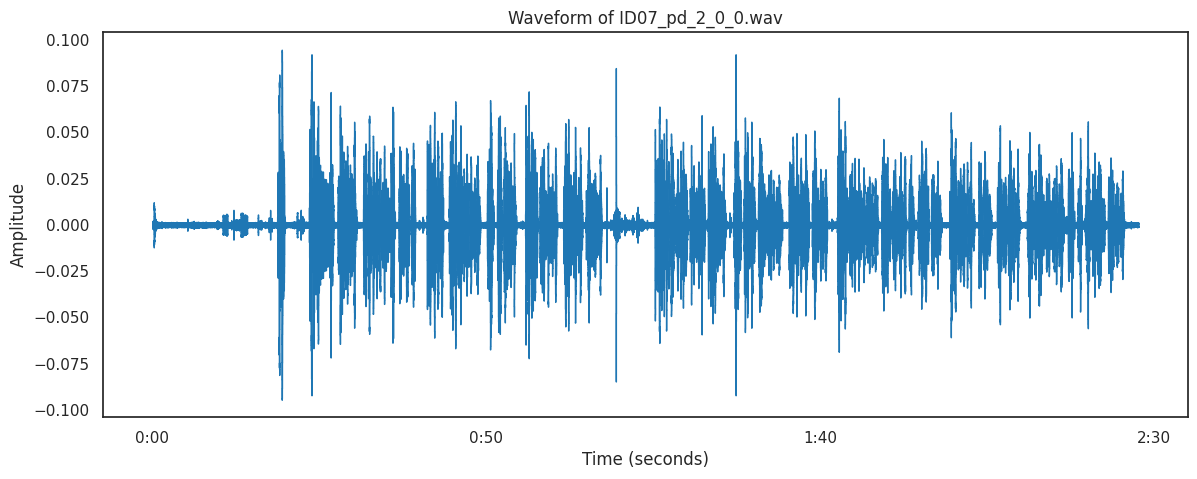

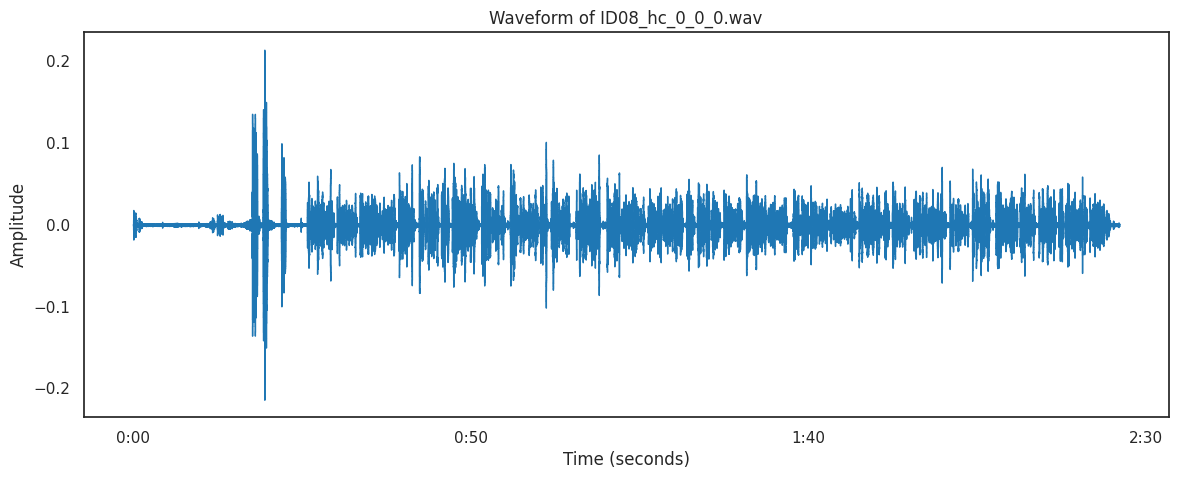

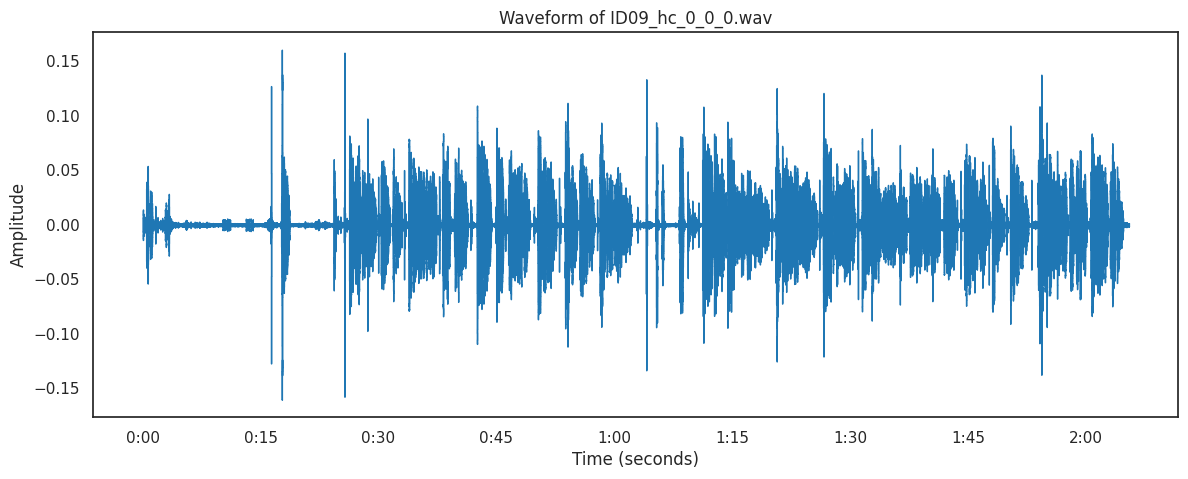

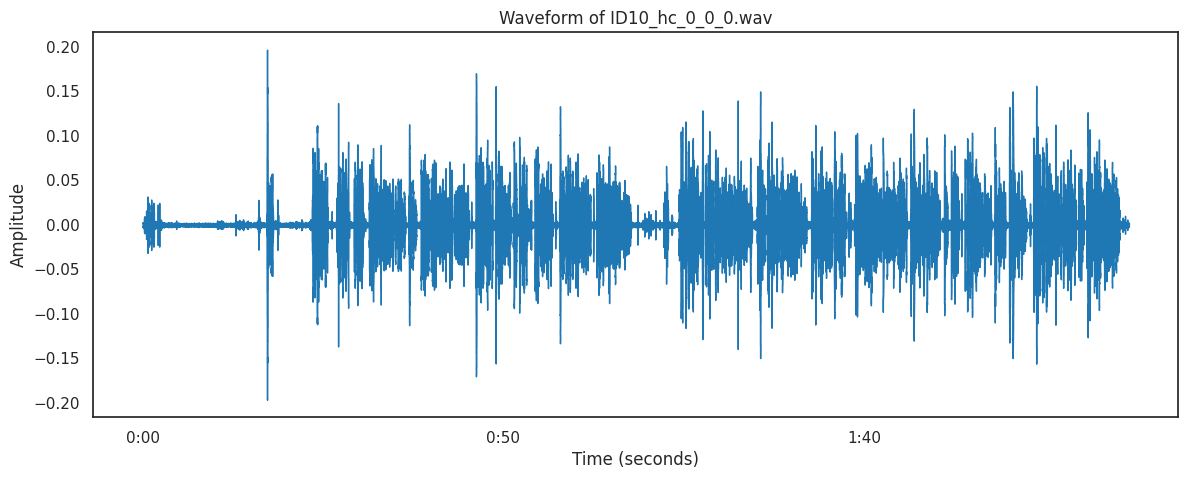

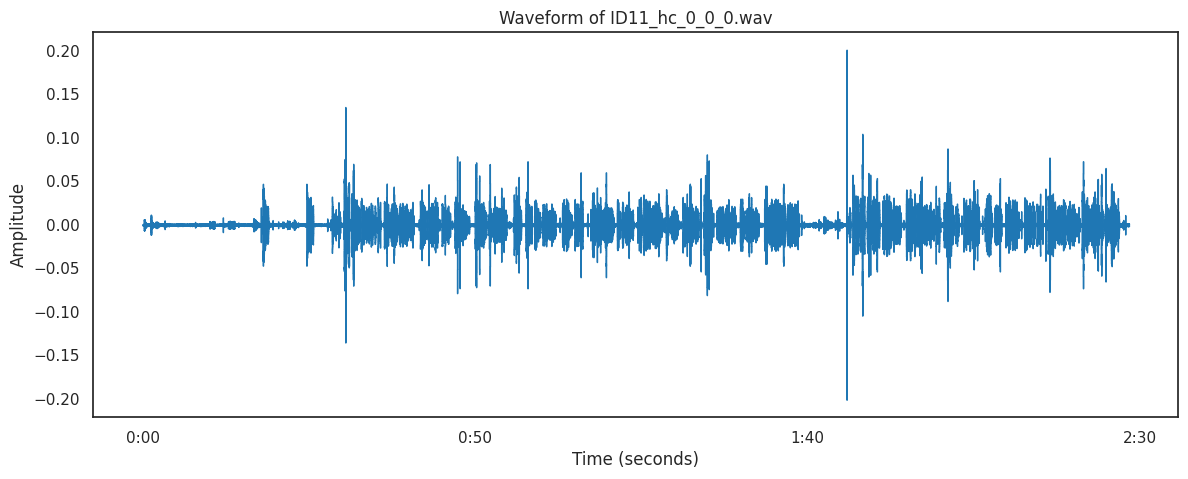

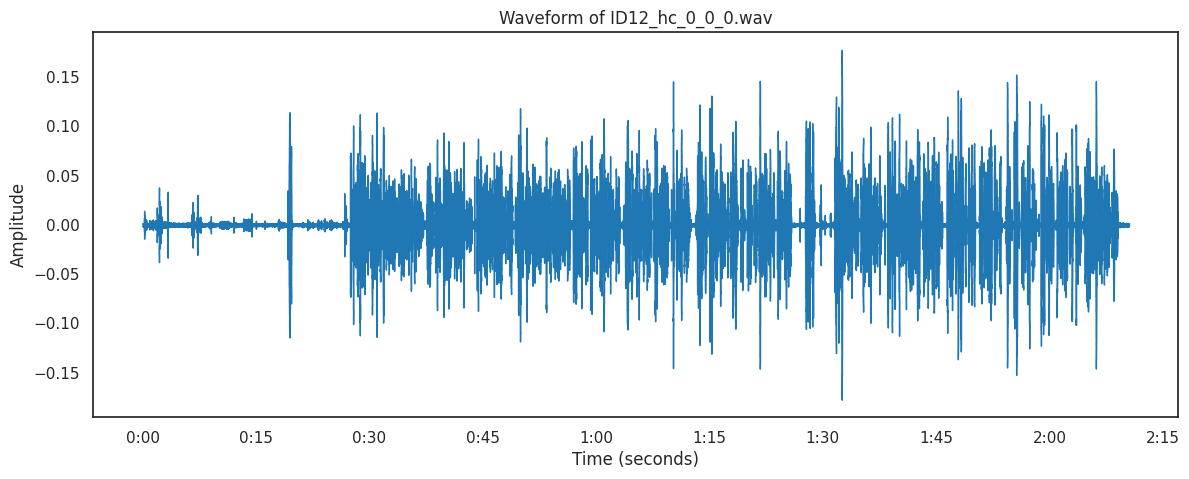

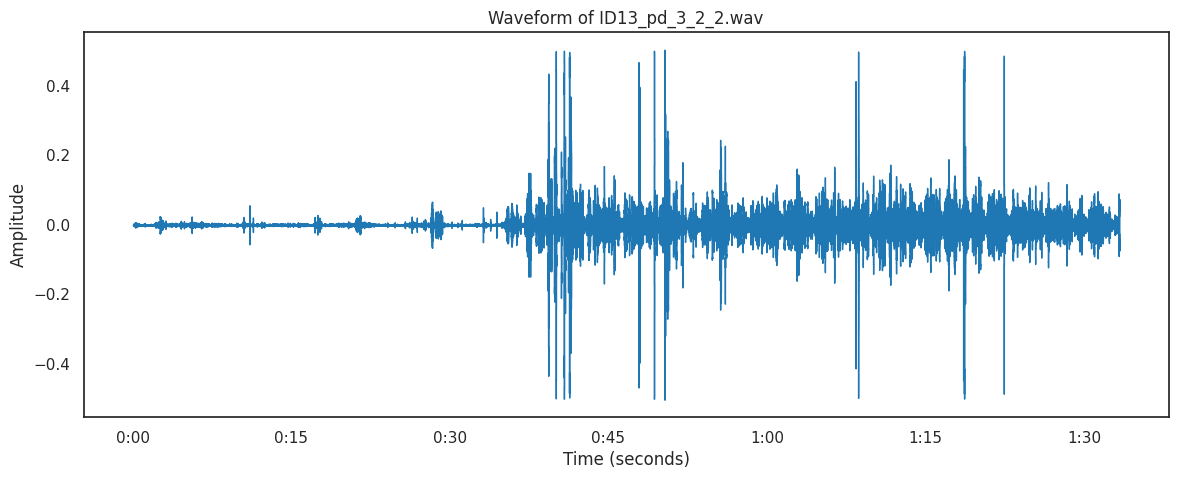

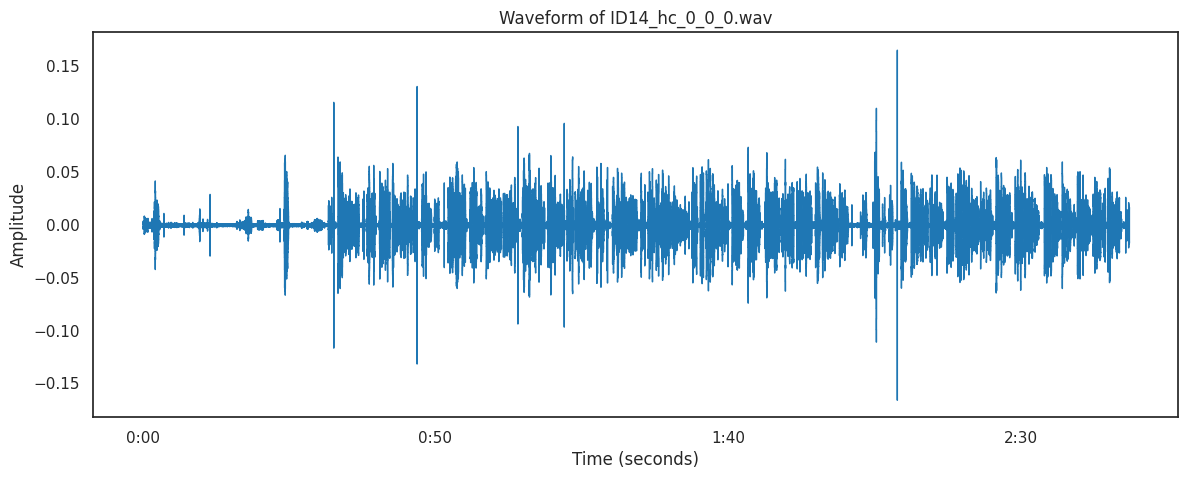

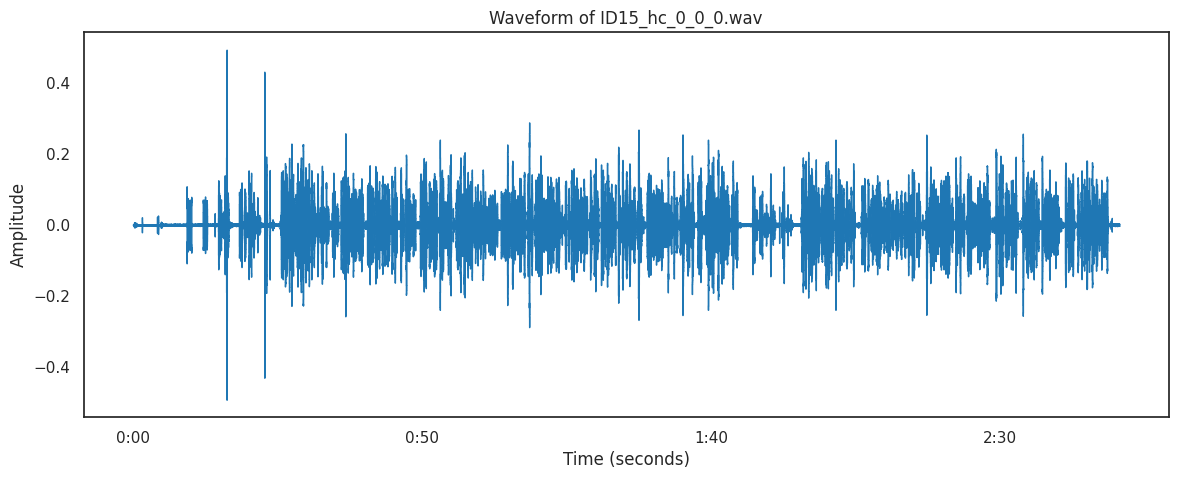

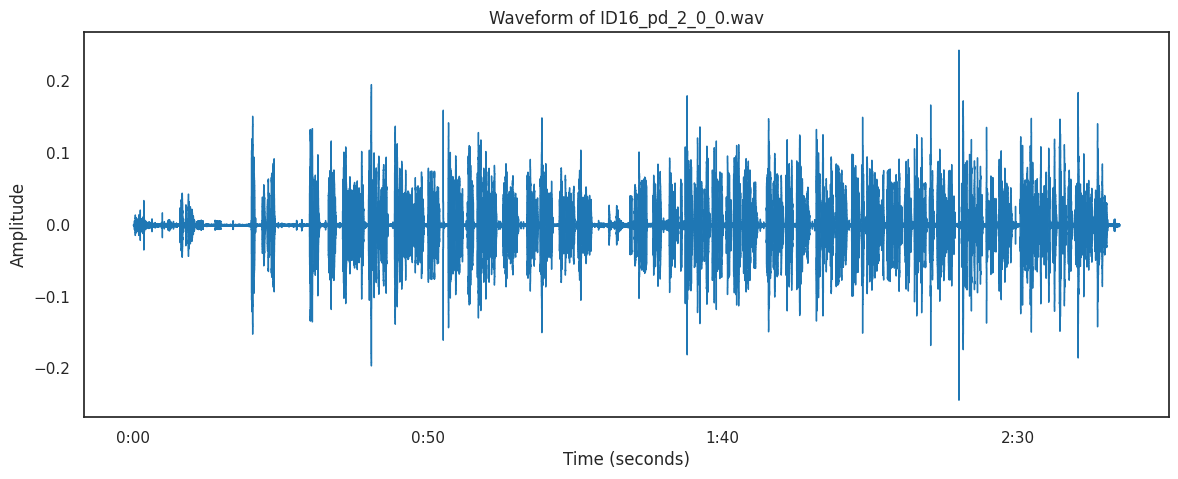

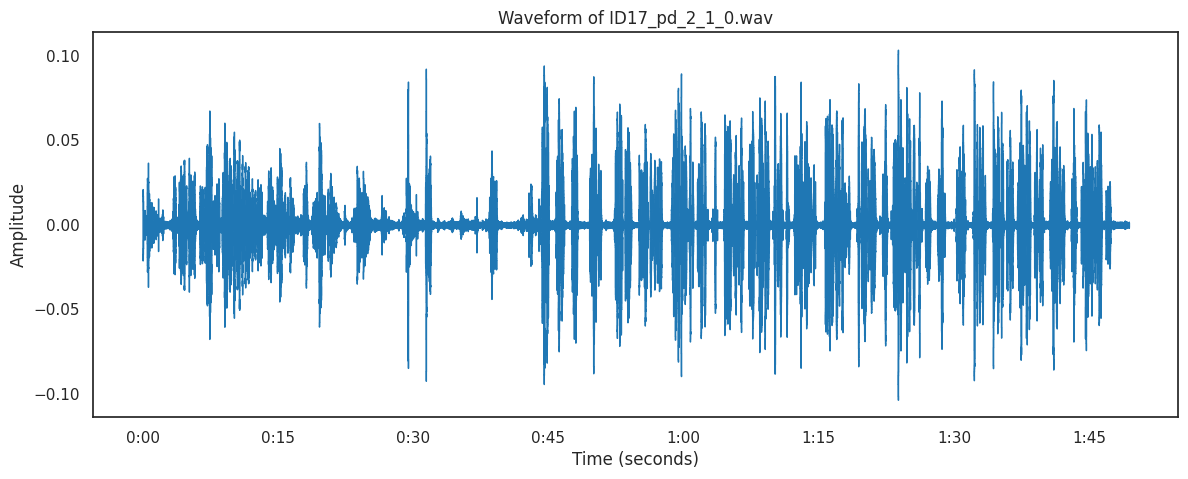

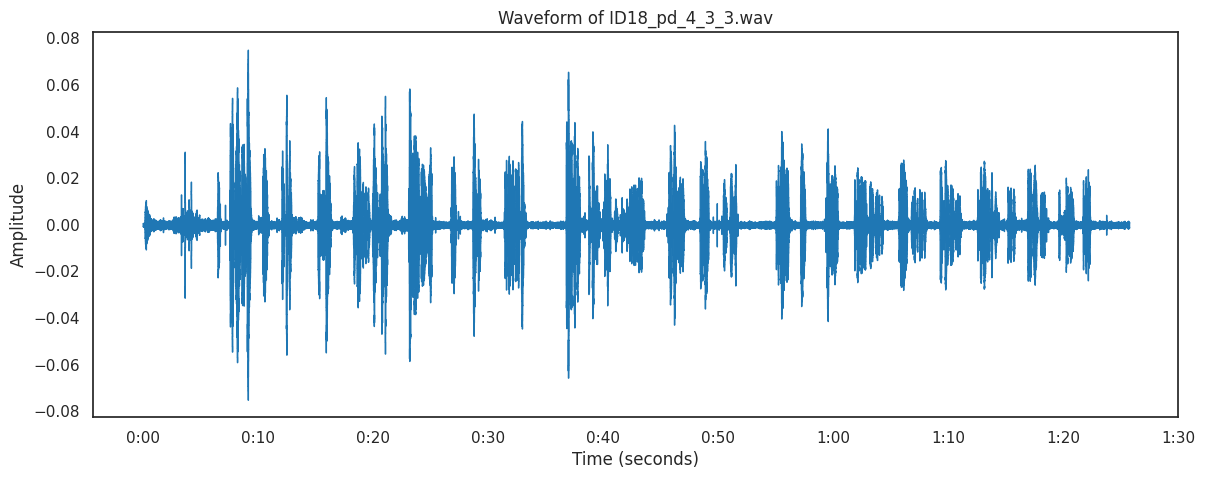

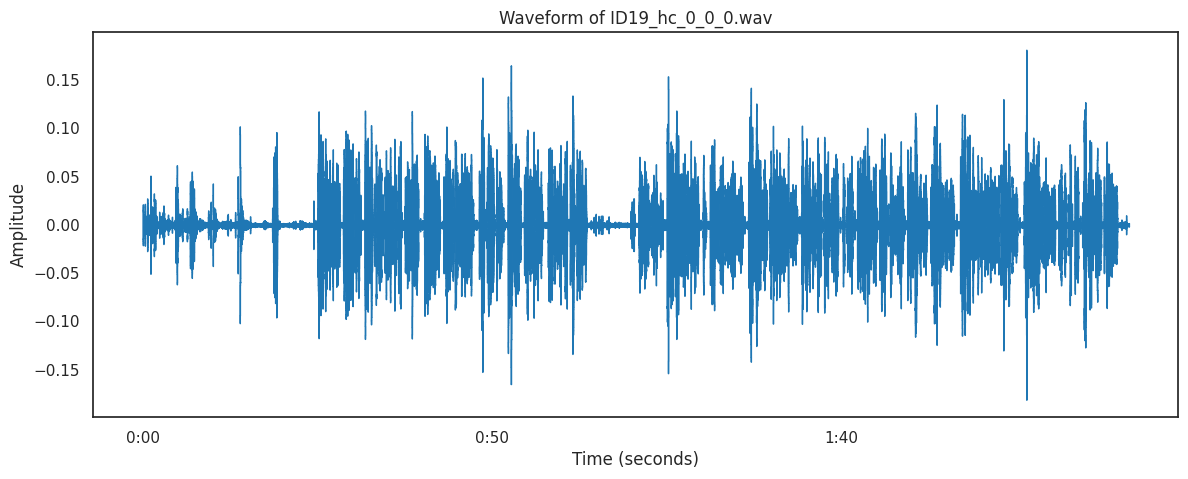

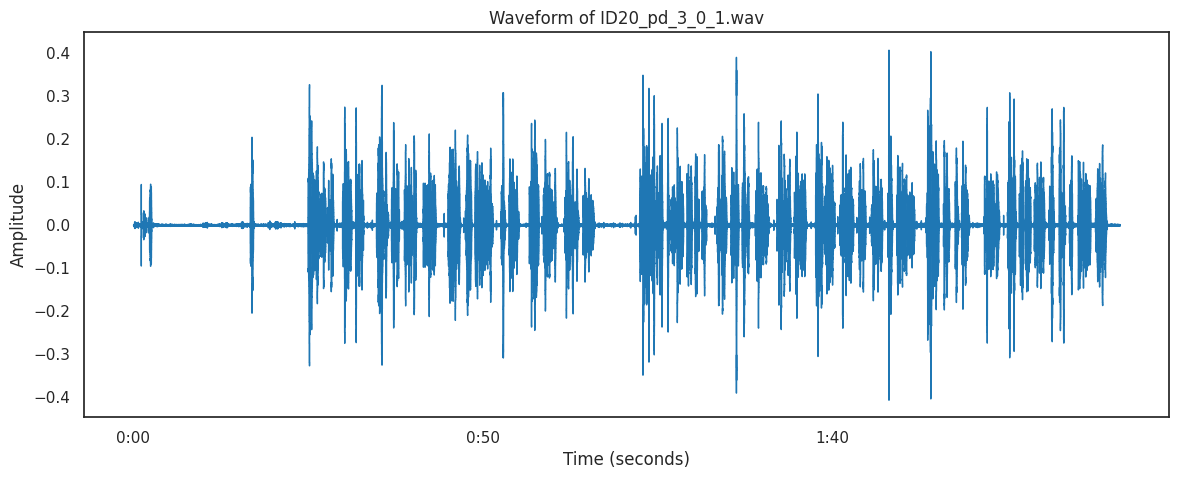

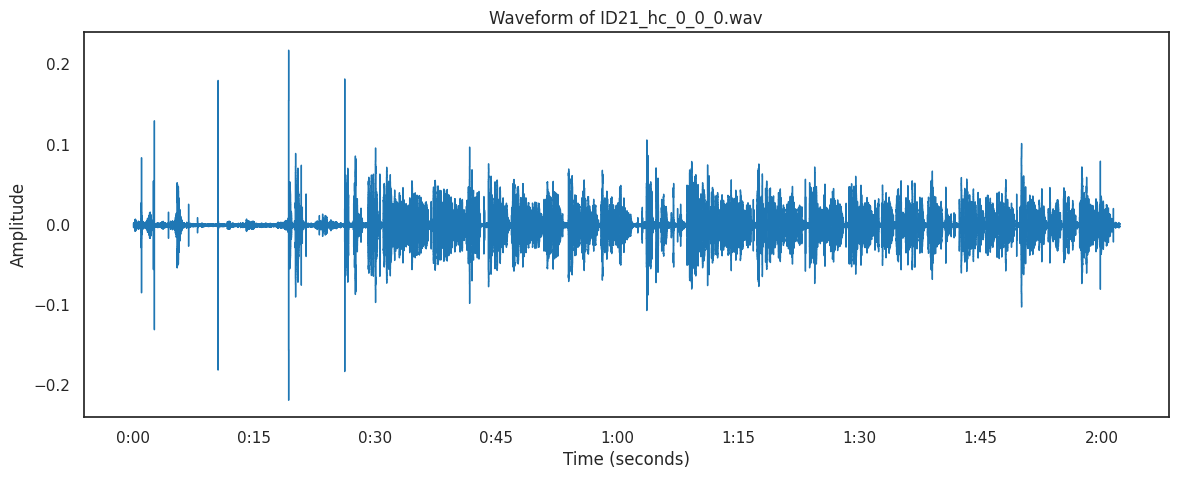

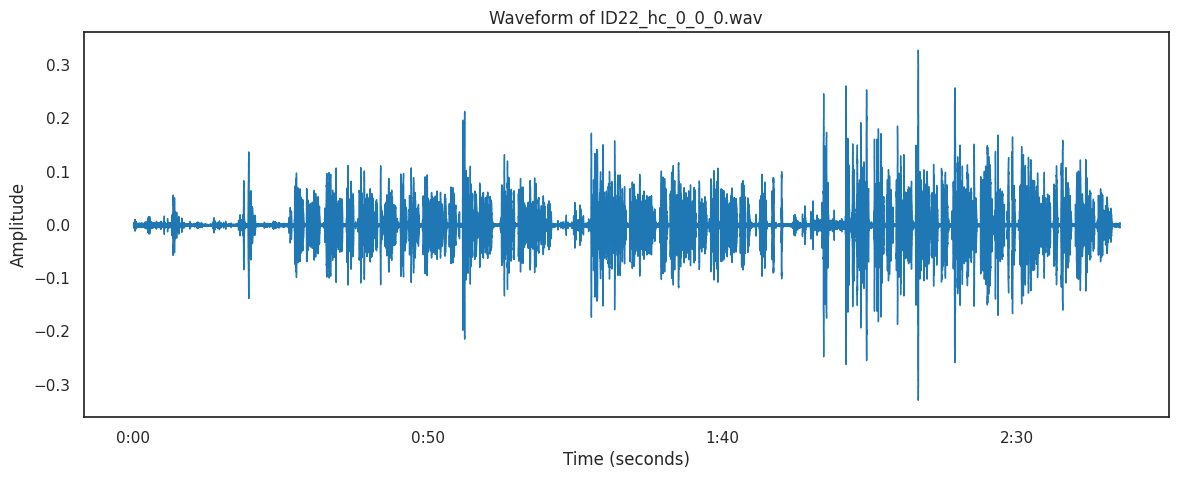

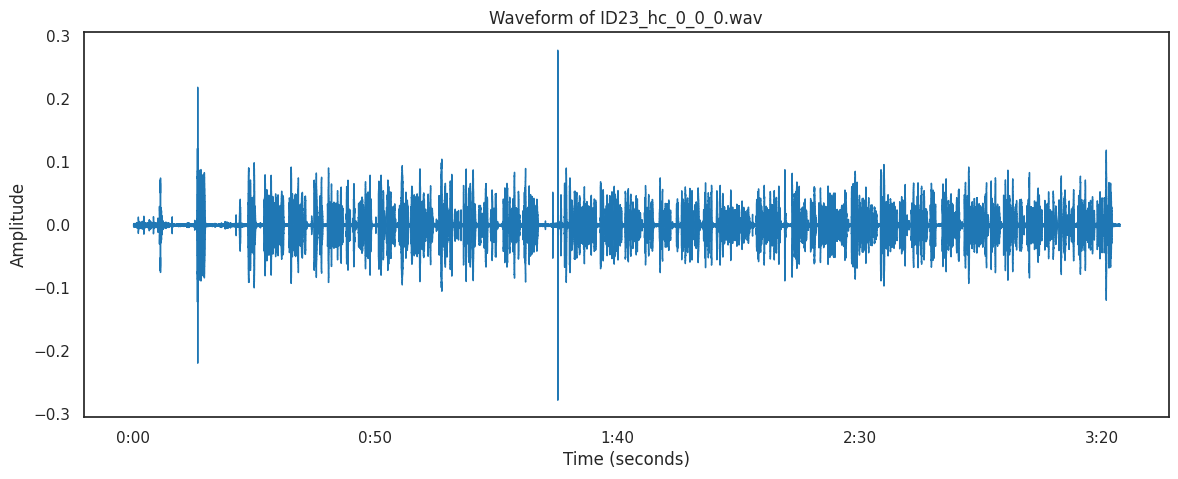

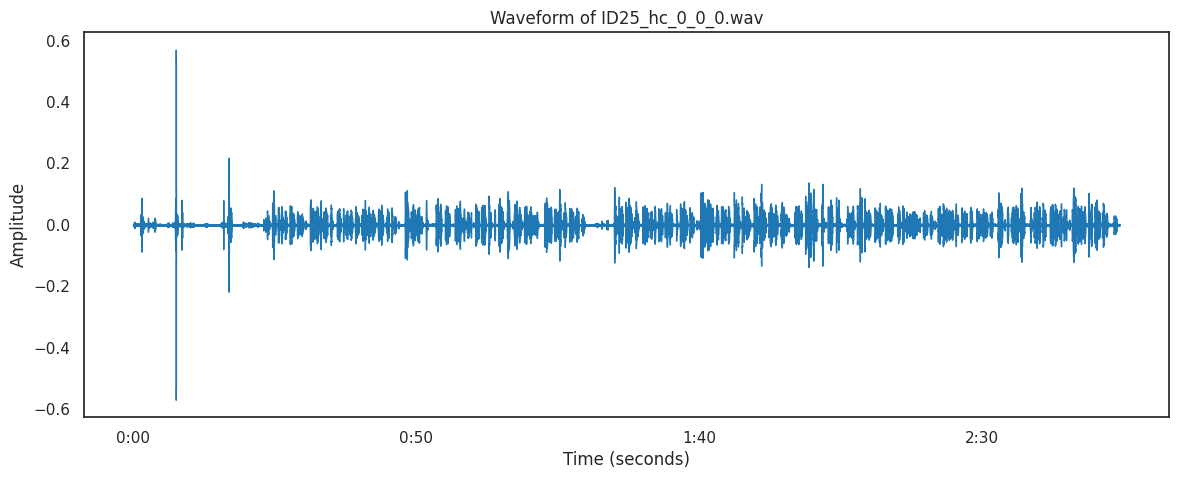

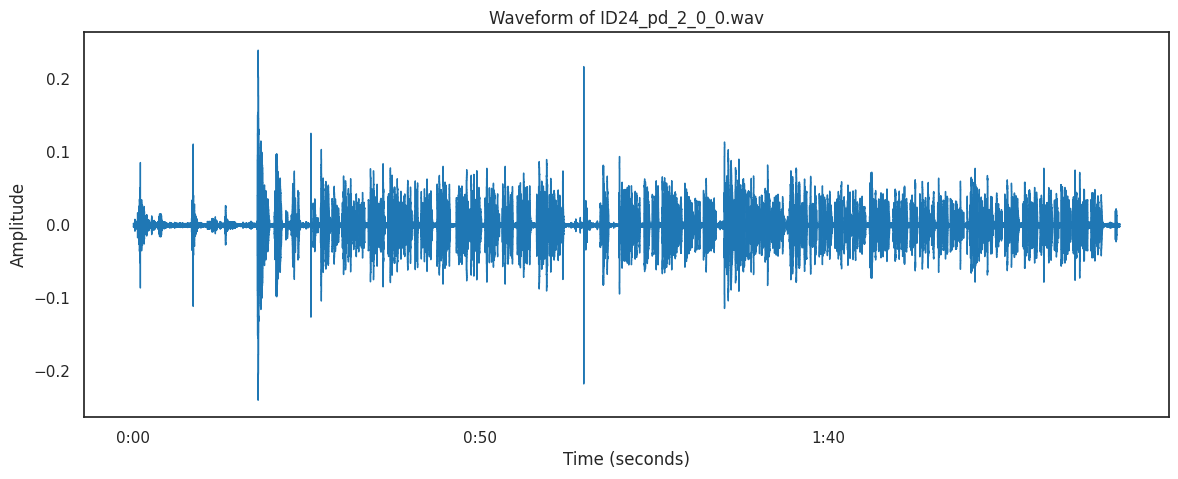

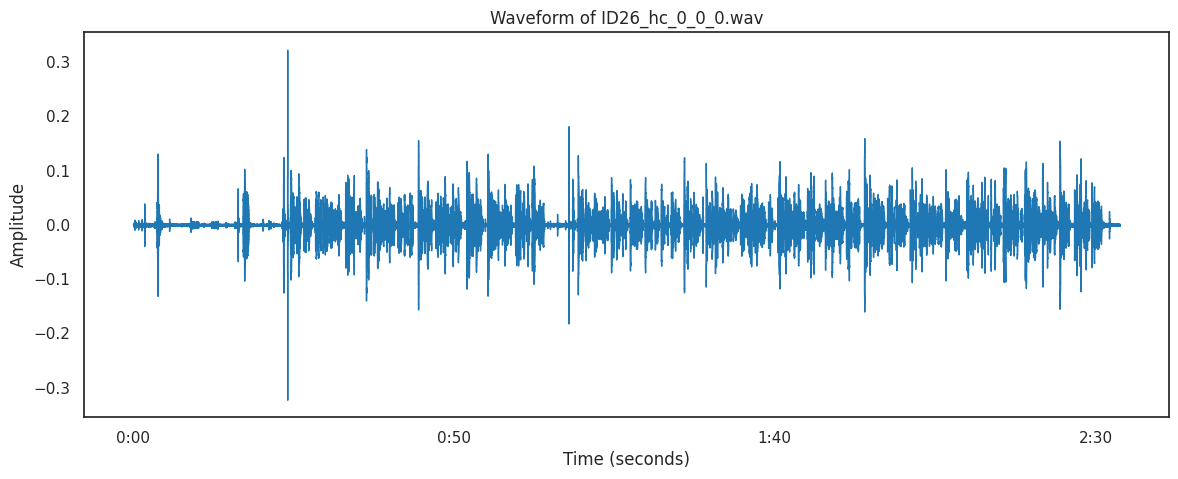

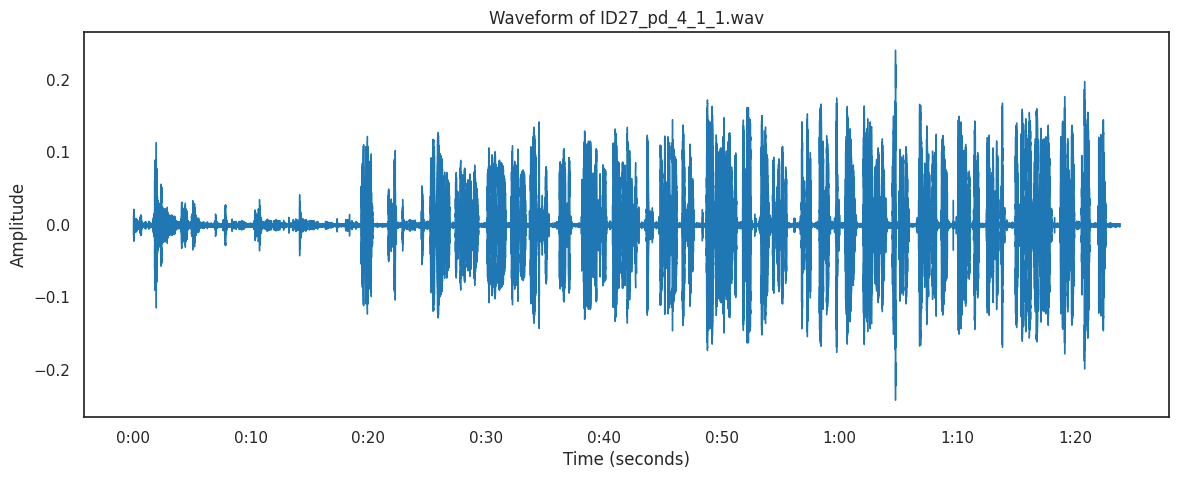

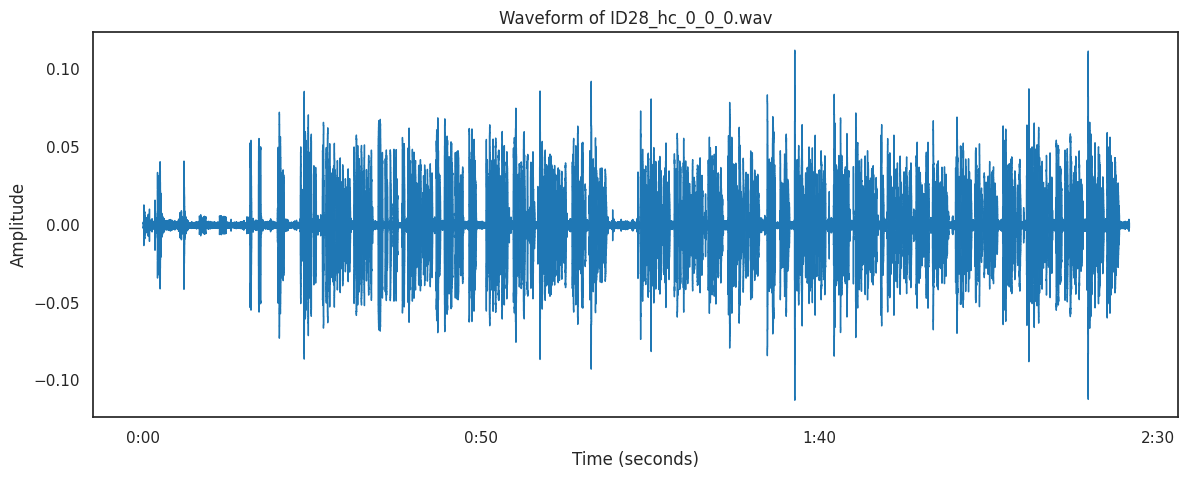

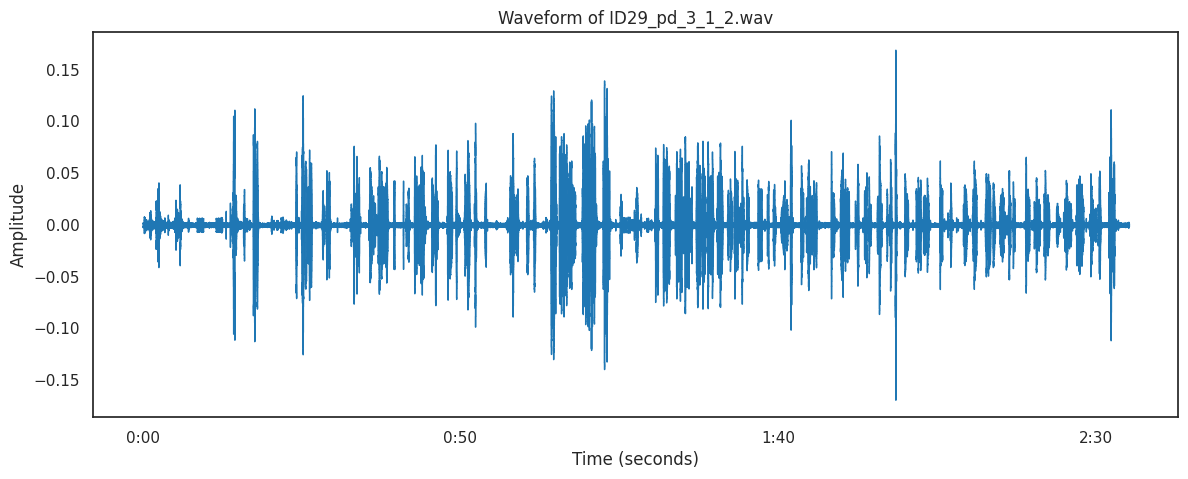

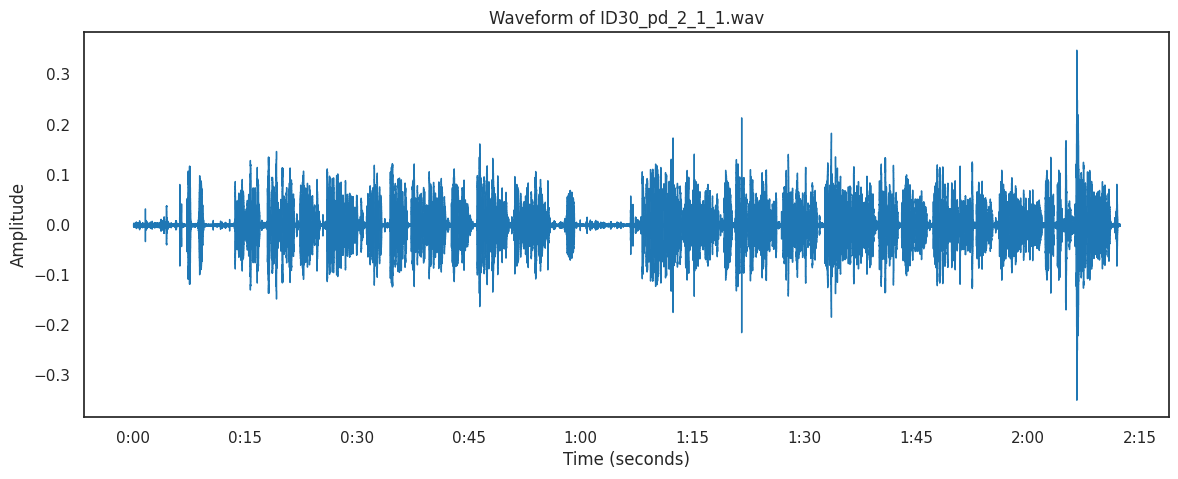

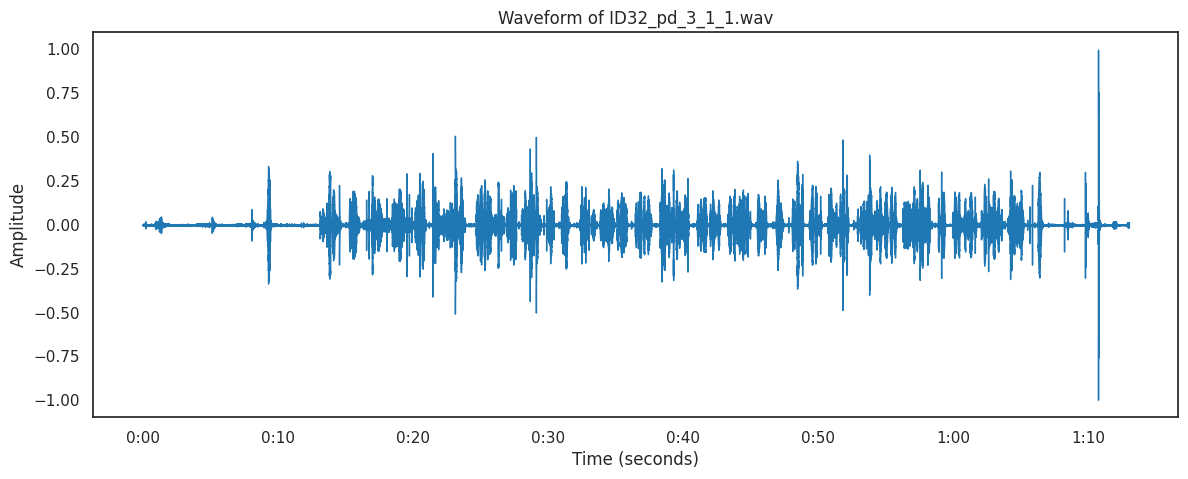

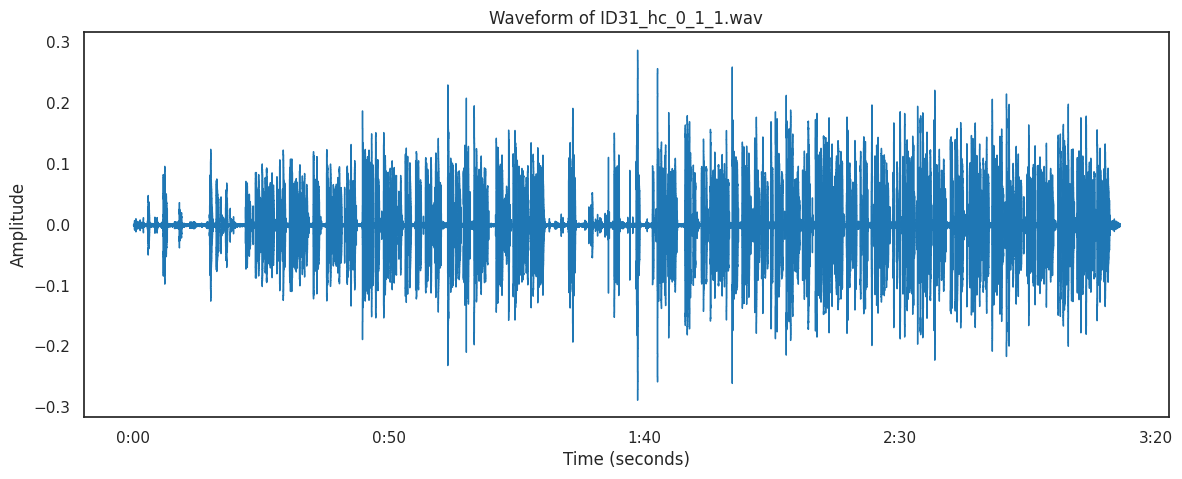

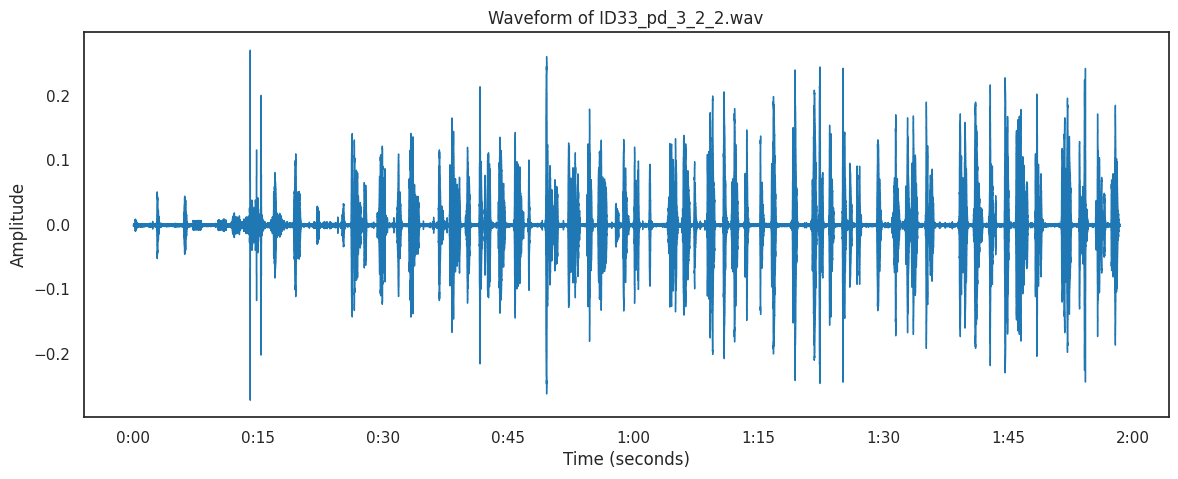

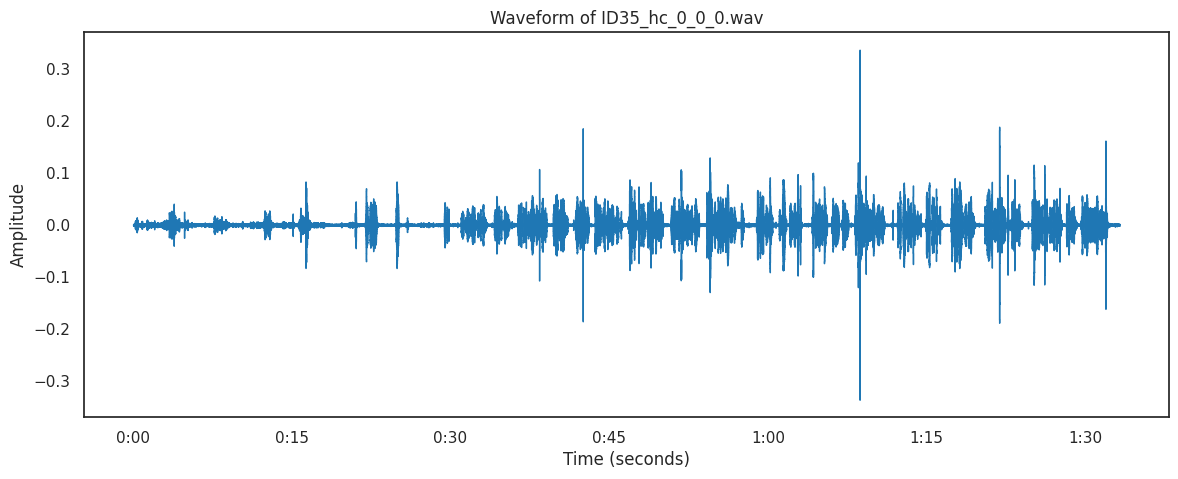

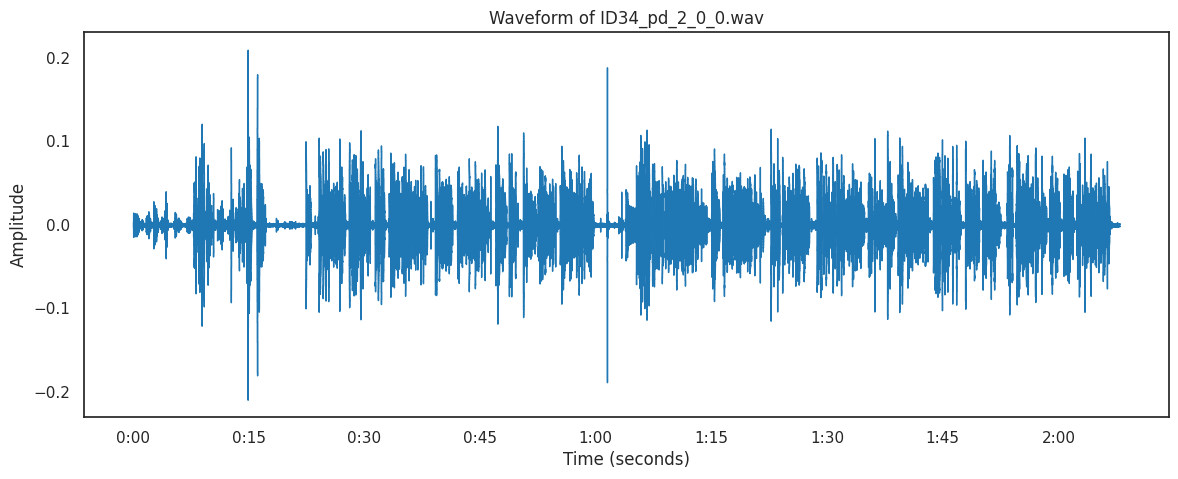

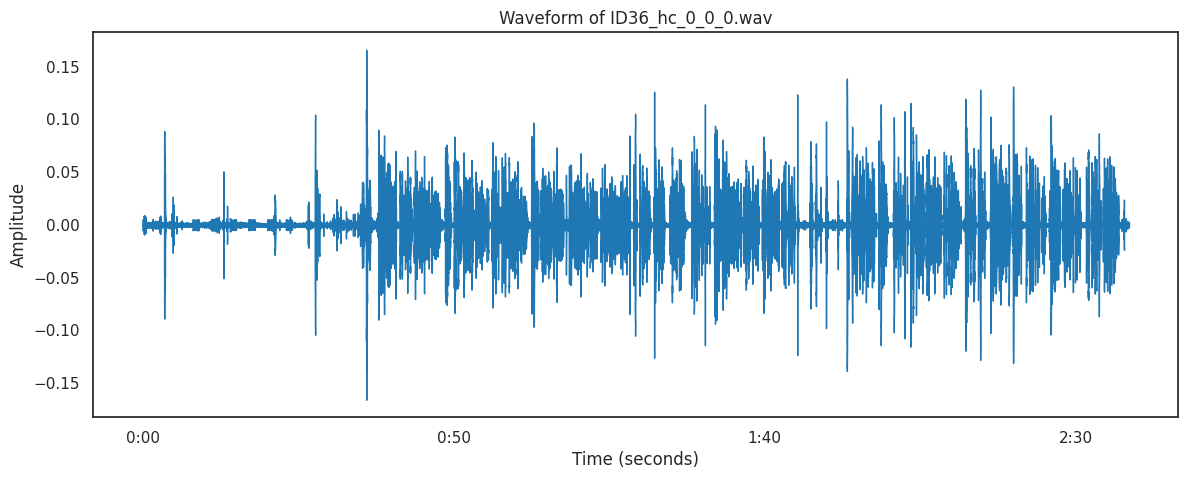

In [ ]:

# Plot the waveform of each audio signal
for i in range(len(signals)):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(signals[i], sr=sr)
    plt.title('Waveform of ' + names[i])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

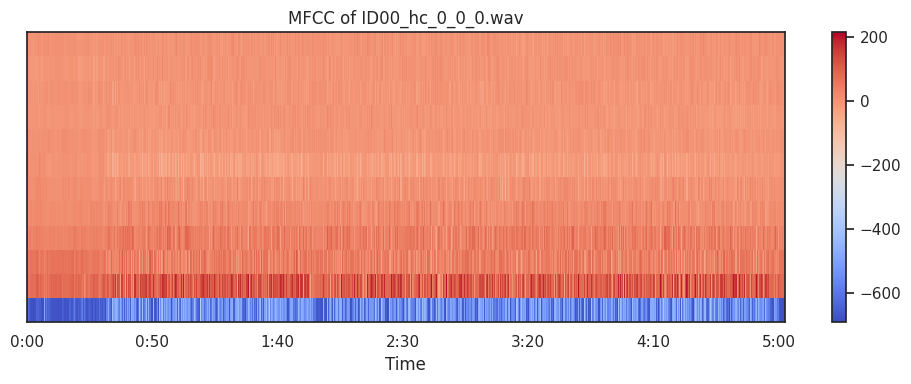

In [ ]:

# Compute and plot the MFCC features of the first audio signal in the dataset
mfccs = librosa.feature.mfcc(y=signals[0], sr=sr, n_mfcc=12)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC of ' + names[0])
plt.tight_layout()
plt.show()


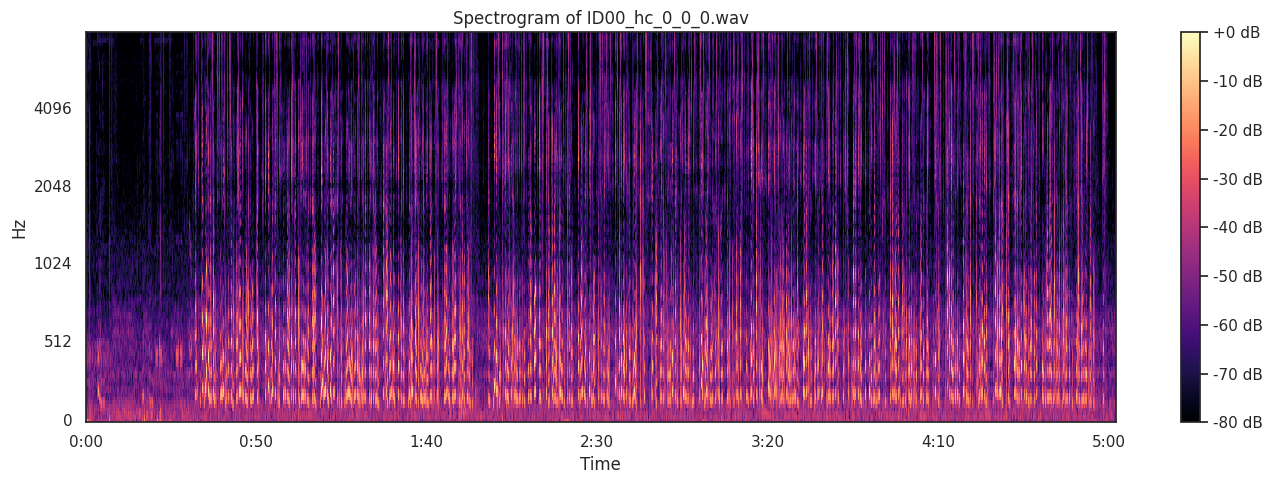

In [ ]:
# Compute and plot the spectrogram of the PD audio signal in the dataset
S = librosa.feature.melspectrogram(y=signals[0], sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(14, 5))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of ' + names[0])
plt.tight_layout()
plt.show()

In [ ]:
#sample_rate
sr

44100

In [ ]:
##check the outliers ...
# Define a function to compute the IQR of a signal
def compute_iqr(signal):
    q1, q3 = np.percentile(signal, [25, 75])
    iqr = q3 - q1
    return iqr

# Loop through all .wav files in the directory and compute their IQRs
iqr_values = []
for filename in os.listdir(dir_path):
    if filename.endswith('.wav'):
        file_path = os.path.join(dir_path, filename)
        # Load the .wav file and extract its data
        sr, data = wavfile.read(file_path)
        # Compute the IQR of the data
        iqr = compute_iqr(data)
        iqr_values.append([filename, iqr])

# Convert the list of IQR values to a DataFrame
iqr_df = pd.DataFrame(iqr_values, columns=['filename', 'iqr'])

# Compute the median and MAD of the IQR values
iqr_median = iqr_df['iqr'].median()
iqr_mad = np.median(np.abs(iqr_df['iqr'] - iqr_median))

# Compute the upper and lower bounds for outliers using the median and MAD
upper_bound = iqr_median + 3 * iqr_mad
lower_bound = iqr_median - 3 * iqr_mad

# Identify the outliers in the IQR values
outliers = iqr_df[(iqr_df['iqr'] > upper_bound) | (iqr_df['iqr'] < lower_bound)]

# Print the filenames of the outliers
print('Outliers:')
print(outliers['filename'].tolist())

Outliers:
['ID01_hc_0_0_0.wav', 'ID13_pd_3_2_2.wav', 'ID15_hc_0_0_0.wav', 'ID30_pd_2_1_1.wav', 'ID32_pd_3_1_1.wav']


In [ ]:

# Convert the list to a DataFrame
df = pd.DataFrame({'filename': outliers['filename'].tolist()})

# Print the DataFrame
print(df)

            filename
0  ID01_hc_0_0_0.wav
1  ID13_pd_3_2_2.wav
2  ID15_hc_0_0_0.wav
3  ID30_pd_2_1_1.wav
4  ID32_pd_3_1_1.wav


In [ ]:
## Check whether the dataset is imbalanced (0=HC , 1 = PD)

metadata=pd.read_csv('/content/drive/MyDrive/Project-code-2023/EXP-wav/data/meta-data.csv')
metadata.head()

VoiceID  label
0  ID00_hc_0_0_0.wav      0
1  ID01_hc_0_0_0.wav      0
2  ID03_hc_0_0_0.wav      0
3  ID05_hc_0_0_0.wav      0
4  ID08_hc_0_0_0.wav      0

In [ ]:
metadata['label'].value_counts()

0    21
1    16
Name: label, dtype: int64

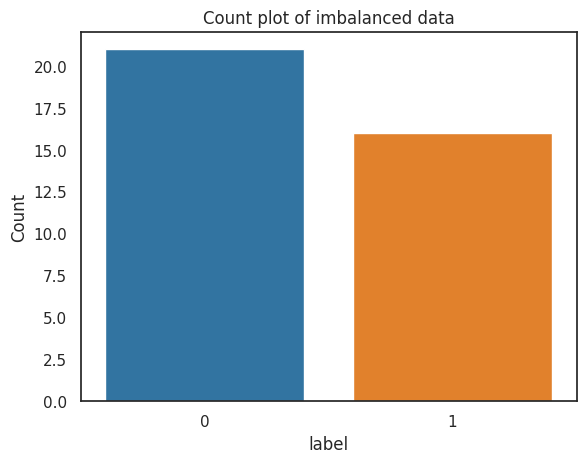

In [ ]:

# Plot the imbalanced data using a count plot
sns.countplot(x='label', data=metadata)
plt.title('Count plot of imbalanced data')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [ ]:
import parselmouth
import pandas as pd
import os

# assume sound_files is a list of audio files in the WAV format
sound_directory = "/content/drive/MyDrive/Project-code-2023/EXP-wav/data"
sound_files = [os.path.join(sound_directory, filename) for filename in os.listdir(sound_directory) if filename.endswith(".wav")]

# set up a list to store the extracted features for each sound file
features_list = []

# loop over each sound file and extract the features
for sound_file in sound_files:
    sound = parselmouth.Sound(sound_file)
    
    # extract mean F0, stdev F0, and HNR
    # extract pitch and standard deviation of pitch
    # extract pitch and mean pitch
    pitch = parselmouth.praat.call(sound, "To Pitch", 0.0, 75, 600)
    mean_pitch = parselmouth.praat.call(pitch, "Get mean", 0, 0, "Hertz")
    f0_max = call(pitch, "Get maximum", 0, 0, "Hertz", "Parabolic") 
    f0_min = call(pitch, "Get minimum", 0, 0, "Hertz", "Parabolic")
    f0_mean = call(pitch, "Get mean", 0, 0, "Hertz") 
    f0_std_deviation= call(pitch, "Get standard deviation", 0, 0, "Hertz") 
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0_min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0_min, f0_max)
    jitter_relative = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    jitter_absolute = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    jitter_rap = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    jitter_ppq5 = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer_relative =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_localDb = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq3 = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq5 = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    # extract MFCC (Mel-frequency cepstral coefficients)
    mfcc = sound.to_mfcc(number_of_coefficients=12)  # extract 12 coefficients
    mfcc_data = mfcc.to_array()
    mfcc_mean = np.mean(mfcc_data.T,axis=0)  # convert to NumPy array
    
    # add the extracted features to the list
    features_list.append([sound_file, f0_mean, f0_std_deviation, hnr,harmonicity, jitter_relative, jitter_absolute, jitter_rap, jitter_ppq5,
                          shimmer_relative, shimmer_localDb, shimmer_apq3, shimmer_apq5] + mfcc_mean.tolist())

# convert the features list to a Pandas DataFrame
columns = ["sound_file", "f0_mean", "f0_std_deviation", "hnr","harmonicity", "jitter_relative", "jitter_absolute", "jitter_rap", "jitter_ppq5",
                          "shimmer_relative", "shimmer_localDb", "shimmer_apq3", "shimmer_apq5"] + [f"mfcc_{i}" for i in range(1, 14)]

df = pd.DataFrame(features_list, columns=columns)

# print the resulting DataFrame
print(df.head())

                                          sound_file     f0_mean  \
0  /content/drive/MyDrive/Project-code-2023/EXP-w...  183.529521   
1  /content/drive/MyDrive/Project-code-2023/EXP-w...  191.411023   
2  /content/drive/MyDrive/Project-code-2023/EXP-w...  124.404377   
3  /content/drive/MyDrive/Project-code-2023/EXP-w...  129.460489   
4  /content/drive/MyDrive/Project-code-2023/EXP-w...  117.594896   

   f0_std_deviation        hnr  \
0         61.706883  12.861531   
1         37.924675  11.191856   
2         30.757396  12.064737   
3         51.693216  13.403747   
4         60.504173  10.182373   

                                         harmonicity  jitter_relative  \
0  Object type: Harmonicity\nObject name: untitle...         0.027656   
1  Object type: Harmonicity\nObject name: untitle...         0.016322   
2  Object type: Harmonicity\nObject name: untitle...         0.021813   
3  Object type: Harmonicity\nObject name: untitle...         0.026465   
4  Object type: Harmo

In [ ]:
df.head(37)

sound_file     f0_mean  \
0   /content/drive/MyDrive/Project-code-2023/EXP-w...  183.529521   
1   /content/drive/MyDrive/Project-code-2023/EXP-w...  191.411023   
2   /content/drive/MyDrive/Project-code-2023/EXP-w...  124.404377   
3   /content/drive/MyDrive/Project-code-2023/EXP-w...  129.460489   
4   /content/drive/MyDrive/Project-code-2023/EXP-w...  117.594896   
5   /content/drive/MyDrive/Project-code-2023/EXP-w...  187.530530   
6   /content/drive/MyDrive/Project-code-2023/EXP-w...  123.080505   
7   /content/drive/MyDrive/Project-code-2023/EXP-w...  139.925796   
8   /content/drive/MyDrive/Project-code-2023/EXP-w...  196.282698   
9   /content/drive/MyDrive/Project-code-2023/EXP-w...  168.134063   
10  /content/drive/MyDrive/Project-code-2023/EXP-w...  204.277715   
11  /content/drive/MyDrive/Project-code-2023/EXP-w...  198.476900   
12  /content/drive/MyDrive/Project-code-2023/EXP-w...  201.499459   
13  /content/drive/MyDrive/Project-code-2023/EXP-w...  189.382582   
14  /content/drive/MyDrive/Project-code-2023/EXP-w...  157.292755   
15  /content/drive/MyDrive/Project-code-2023/EXP-w...  165.444079   
16  /content/drive/MyDrive/Project-code-2023/EXP-w...  210.234302   
17  /content/drive/MyDrive/Project-code-2023/EXP-w...  188.098210   
18  /content/drive/MyDrive/Project-code-2023/EXP-w...  140.355185   
19  /content/drive/MyDrive/Project-code-2023/EXP-w...  155.509745   
20  /content/drive/MyDrive/Project-code-2023/EXP-w...  131.268282   
21  /content/drive/MyDrive/Project-code-2023/EXP-w...  160.776599   
22  /content/drive/MyDrive/Project-code-2023/EXP-w...  175.887201   
23  /content/drive/MyDrive/Project-code-2023/EXP-w...  180.955867   
24  /content/drive/MyDrive/Project-code-2023/EXP-w...  199.726333   
25  /content/drive/MyDrive/Project-code-2023/EXP-w...  127.917260   
26  /content/drive/MyDrive/Project-code-2023/EXP-w...  183.512618   
27  /content/drive/MyDrive/Project-code-2023/EXP-w...  101.441520   
28  /content/drive/MyDrive/Project-code-2023/EXP-w...  197.827395   
29  /content/drive/MyDrive/Project-code-2023/EXP-w...  134.131166   
30  /content/drive/MyDrive/Project-code-2023/EXP-w...  214.070181   
31  /content/drive/MyDrive/Project-code-2023/EXP-w...  167.006778   
32  /content/drive/MyDrive/Project-code-2023/EXP-w...  214.506157   
33  /content/drive/MyDrive/Project-code-2023/EXP-w...  185.074451   
34  /content/drive/MyDrive/Project-code-2023/EXP-w...  184.918946   
35  /content/drive/MyDrive/Project-code-2023/EXP-w...  186.913251   
36  /content/drive/MyDrive/Project-code-2023/EXP-w...  139.155344   

    f0_std_deviation        hnr  \
0          61.706883  12.861531   
1          37.924675  11.191856   
2          30.757396  12.064737   
3          51.693216  13.403747   
4          60.504173  10.182373   
5          58.369621  12.069858   
6          24.160076  12.484617   
7          47.498626  12.317105   
8          43.314711  14.251459   
9          36.338894  12.738798   
10         52.510545  12.364233   
11         42.022231  15.619031   
12         50.247392  11.644205   
13        117.764128  11.309593   
14         47.137326  13.103552   
15         59.550302  11.284447   
16         39.254406  16.155950   
17         47.806508  13.600805   
18         48.976798  15.914919   
19         48.090808  11.127860   
20         25.027481  13.862088   
21         34.039663  12.883830   
22         45.150739  13.861434   
23         44.392800  16.240037   
24         50.600252  17.586959   
25         21.700405  14.606787   
26         46.963355  12.811866   
27         42.236439  13.447251   
28         62.770765  12.767706   
29         59.880301  14.448211   
30         47.232220  13.979674   
31         33.006257  10.920765   
32         40.106692  15.221885   
33         36.869650  16.909752   
34         54.561750  15.021777   
35         57.786169  13.742015   
36         34.546578  11.037454   

                                          harmonicity  jitter_relative  \
0   Object type

In [ ]:
label = [0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,0]
df['label'] = label 

In [ ]:
print('Number of Features In Dataset :', df.shape[1])
print('Number of Instances In Dataset : ', df.shape[0])

Number of Features In Dataset : 27
Number of Instances In Dataset :  37


In [ ]:
dff=df

In [ ]:
#The column "sound_file", is a Redundant column which is not useful for Analysis or Machine Learning, and will be dropped from the dataframe.

dff.drop(['sound_file','harmonicity'], axis=1, inplace=True)

In [ ]:
# Exploring Information About Dataframe
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   f0_mean           37 non-null     float64
 1   f0_std_deviation  37 non-null     float64
 2   hnr               37 non-null     float64
 3   jitter_relative   37 non-null     float64
 4   jitter_absolute   37 non-null     float64
 5   jitter_rap        37 non-null     float64
 6   jitter_ppq5       37 non-null     float64
 7   shimmer_relative  37 non-null     float64
 8   shimmer_localDb   37 non-null     float64
 9   shimmer_apq3      37 non-null     float64
 10  shimmer_apq5      37 non-null     float64
 11  mfcc_1            37 non-null     float64
 12  mfcc_2            37 non-null     float64
 13  mfcc_3            37 non-null     float64
 14  mfcc_4            37 non-null     float64
 15  mfcc_5            37 non-null     float64
 16  mfcc_6            37 non-null     float64
 17 

In [ ]:
dff.describe()

f0_mean  f0_std_deviation        hnr  jitter_relative  \
count   37.000000         37.000000  37.000000        37.000000   
mean   169.108491         47.094601  13.379464         0.023551   
std     31.054132         16.044581   1.821215         0.005570   
min    101.441520         21.700405  10.182373         0.013970   
25%    139.925796         37.924675  12.069858         0.020194   
50%    180.955867         47.137326  13.103552         0.022866   
75%    191.411023         52.510545  14.448211         0.027047   
max    214.506157        117.764128  17.586959         0.039906   

       jitter_absolute  jitter_rap  jitter_ppq5  shimmer_relative  \
count        37.000000   37.000000    37.000000         37.000000   
mean          0.000150    0.010216     0.010979          0.096420   
std           0.000062    0.002904     0.002928          0.020811   
min           0.000077    0.005358     0.005803          0.061226   
25%           0.000112    0.008341     0.009115          0.082022   
50%           0.000131    0.009922     0.010434          0.095637   
75%           0.000187    0.011550     0.013075          0.105201   
max           0.000343    0.017347     0.018509          0.179187   

       shimmer_localDb  shimmer_apq3  ...     mfcc_5     mfcc_6     mfcc_7  \
count        37.000000     37.000000  ...  37.000000  37.000000  37.000000   
mean          0.942493      0.036719  ...  26.983006  24.534434 -14.658999   
std           0.173447      0.010067  ...  12.726663  14.297257  15.035068   
min           0.635766      0.023806  ...  -9.612589  -1.269567 -51.226759   
25%           0.806059      0.029279  ...  20.603586  12.465326 -20.877052   
50%           0.962213      0.035398  ...  25.994576  25.461889 -15.199401   
75%           1.030768      0.040809  ...  36.367023  35.371636  -7.150892   
max           1.557051      0.071358  ...  51.931076  50.608532  36.373886   

          mfcc_8     mfcc_9    mfcc_10    mfcc_11    mfcc_12    mfcc_13  \
count  37.000000  37.000000  37.000000  37.000000  37.000000  37.000000   
mean   -2.344370 -12.186701  -3.743819   0.003344  -1.294651   1.061976   
std    13.249363  11.363720  11.363840   9.653106   7.705090   8.945486   
min   -24.561546 -35.680011 -40.630948 -28.457065 -16.292199 -16.042029   
25%   -11.787999 -17.471027 -12.009368  -5.214899  -6.654626  -5.702192   
50%    -1.961568 -13.068323   0.028050   0.381197  -1.466902   1.554965   
75%     5.476300  -3.977438   5.188163   4.421726   3.519430   8.576886   
max    34.894468  19.013661  16.090623  19.289492  20.126116  17.294757   

           label  
count  37.000000  
mean    0.432432  
std     0.502247  
min     0.000000  
25%     0.000000  
50%     0.000000  
75%     1.000000  
max     1.000000  

[8 rows x 25 columns]

In [ ]:
# Checking For Duplicate Rows In Dataset
print('Number of Duplicated Rows :',df.duplicated().sum())

Number of Duplicated Rows : 0


In [ ]:
# Checking For Missing Values In Dataset
df.isna().sum()

f0_mean             0
f0_std_deviation    0
hnr                 0
jitter_relative     0
jitter_absolute     0
jitter_rap          0
jitter_ppq5         0
shimmer_relative    0
shimmer_localDb     0
shimmer_apq3        0
shimmer_apq5        0
mfcc_1              0
mfcc_2              0
mfcc_3              0
mfcc_4              0
mfcc_5              0
mfcc_6              0
mfcc_7              0
mfcc_8              0
mfcc_9              0
mfcc_10             0
mfcc_11             0
mfcc_12             0
mfcc_13             0
label               0
dtype: int64

<Axes: >

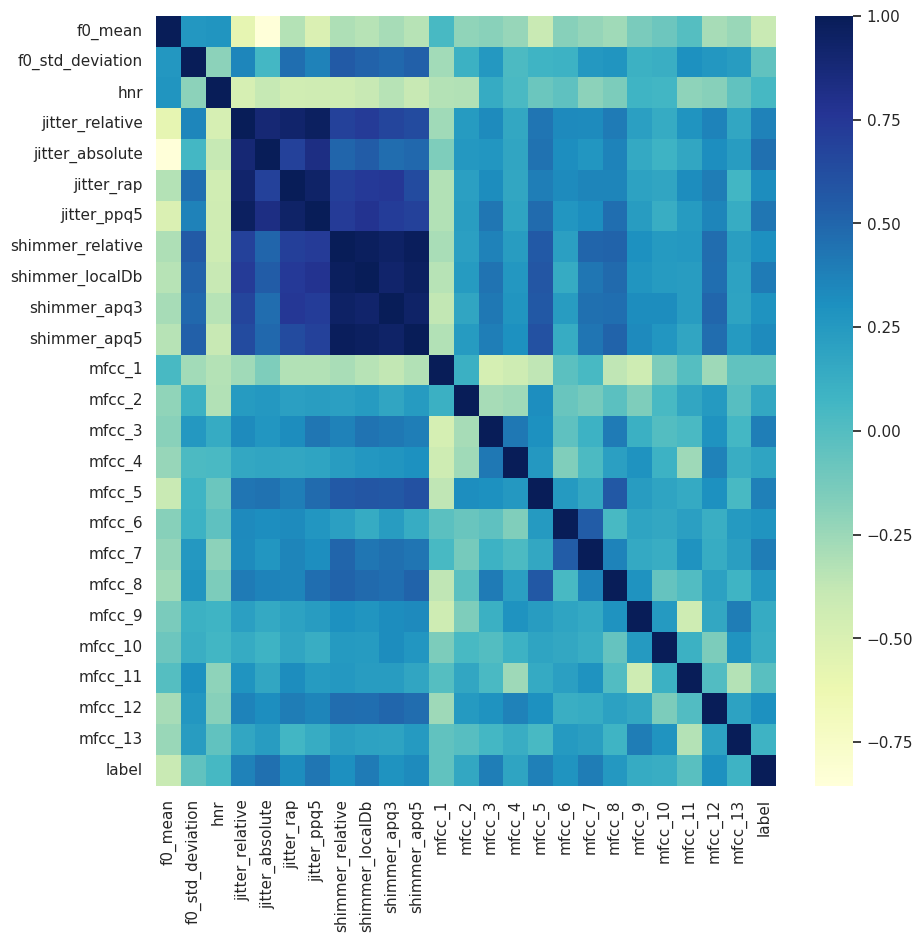

In [ ]:
#check the correlation ..
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df.corr(),annot=False,ax=ax,cmap="YlGnBu")

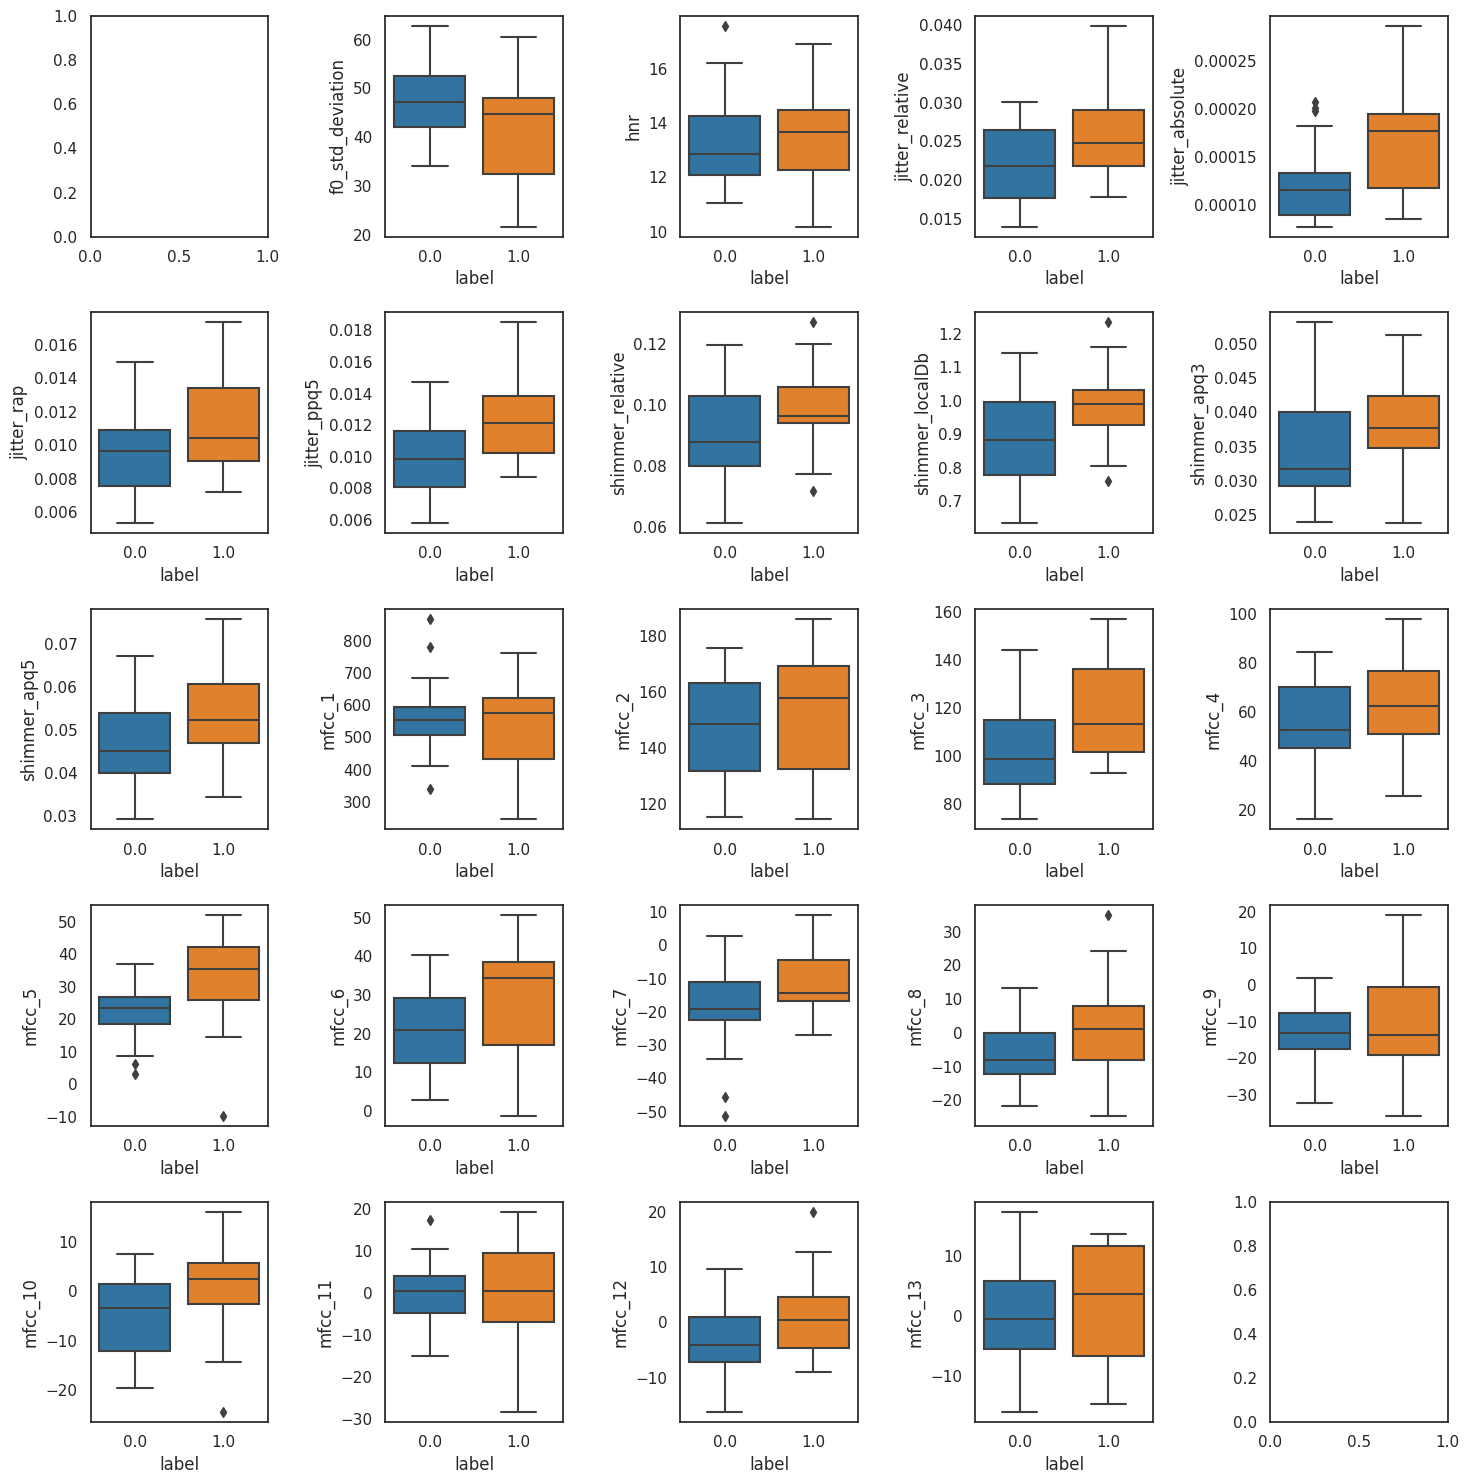

In [ ]:
#Box Plot
fig,axes=plt.subplots(5,5,figsize=(15,15))
axes=axes.flatten()

for i in range(1,len(df.columns)-1):
    sns.boxplot(x='label',y=df.iloc[:,i],data=df,orient='v',ax=axes[i])
plt.tight_layout()
plt.show()

In [ ]:
# loop through each feature
for feature in df.columns:
    # calculate the Z-score for each data point in the feature
    z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())

    # identify outliers
    outliers = np.where(z_scores > 3)

    # print the number of outliers in each feature
    print(f"Feature '{feature}' has {len(outliers[0])} outliers.")

Feature 'f0_mean' has 0 outliers.
Feature 'f0_std_deviation' has 1 outliers.
Feature 'hnr' has 0 outliers.
Feature 'jitter_relative' has 0 outliers.
Feature 'jitter_absolute' has 1 outliers.
Feature 'jitter_rap' has 0 outliers.
Feature 'jitter_ppq5' has 0 outliers.
Feature 'shimmer_relative' has 1 outliers.
Feature 'shimmer_localDb' has 1 outliers.
Feature 'shimmer_apq3' has 1 outliers.
Feature 'shimmer_apq5' has 1 outliers.
Feature 'mfcc_1' has 0 outliers.
Feature 'mfcc_2' has 0 outliers.
Feature 'mfcc_3' has 0 outliers.
Feature 'mfcc_4' has 0 outliers.
Feature 'mfcc_5' has 0 outliers.
Feature 'mfcc_6' has 0 outliers.
Feature 'mfcc_7' has 1 outliers.
Feature 'mfcc_8' has 0 outliers.
Feature 'mfcc_9' has 0 outliers.
Feature 'mfcc_10' has 1 outliers.
Feature 'mfcc_11' has 0 outliers.
Feature 'mfcc_12' has 0 outliers.
Feature 'mfcc_13' has 0 outliers.
Feature 'label' has 0 outliers.


In [ ]:
# loop through each feature to find and adjust the outliers..
for feature in df.columns:
    # calculate the Z-score for each data point in the feature
    z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())

    # identify outliers
    outliers = np.where(z_scores > 3)

    # adjust outliers to the mean value
    df.loc[outliers[0], feature] = df[feature].mean()

# print the adjusted data frame
df.head()

f0_mean  f0_std_deviation        hnr  jitter_relative  jitter_absolute  \
0  183.529521         61.706883  12.861531         0.027656         0.000152   
1  191.411023         37.924675  11.191856         0.016322         0.000085   
2  124.404377         30.757396  12.064737         0.021813         0.000176   
3  129.460489         51.693216  13.403747         0.026465         0.000208   
4  117.594896         60.504173  10.182373         0.039906         0.000150   

   jitter_rap  jitter_ppq5  shimmer_relative  shimmer_localDb  shimmer_apq3  \
0    0.012301     0.013581          0.114328         1.142765      0.046059   
1    0.006892     0.007165          0.078771         0.735034      0.028917   
2    0.008341     0.009774          0.105201         1.003543      0.041027   
3    0.010665     0.011645          0.104704         1.002982      0.040266   
4    0.017347     0.018509          0.127223         1.232997      0.048521   

   ...     mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfcc_9   mfcc_10  \
0  ...  36.622796   4.381283 -51.226759 -21.675977  -7.684882  2.750536   
1  ...  22.481075  22.888370 -16.576583  -0.005128 -22.860485 -1.250413   
2  ...  28.954005   9.337745  -5.015254   2.583235 -14.572674  0.940267   
3  ...  31.359476  33.517867 -34.057906 -12.091941 -11.613016 -3.418581   
4  ...  34.587242  35.904514  -7.150892   1.812661 -14.583591  4.764799   

     mfcc_11   mfcc_12   mfcc_13  label  
0   3.849808  8.752428  0.208220    0.0  
1  -8.307896 -7.638449  0.425119    0.0  
2  -5.533343 -1.466902 -9.954152    1.0  
3 -15.054758  1.423258  7.775569    0.0  
4  11.591349 -2.477217  8.576886    1.0  

[5 rows x 25 columns]

In [ ]:
# loop through each feature
for feature in df.columns:
    # calculate the Z-score for each data point in the feature
    z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())

    # identify outliers
    outliers = np.where(z_scores > 3)

    # print the number of outliers in each feature
    print(f"Feature '{feature}' has {len(outliers[0])} outliers.")

Feature 'f0_mean' has 0 outliers.
Feature 'f0_std_deviation' has 0 outliers.
Feature 'hnr' has 0 outliers.
Feature 'jitter_relative' has 0 outliers.
Feature 'jitter_absolute' has 0 outliers.
Feature 'jitter_rap' has 0 outliers.
Feature 'jitter_ppq5' has 0 outliers.
Feature 'shimmer_relative' has 0 outliers.
Feature 'shimmer_localDb' has 0 outliers.
Feature 'shimmer_apq3' has 0 outliers.
Feature 'shimmer_apq5' has 0 outliers.
Feature 'mfcc_1' has 0 outliers.
Feature 'mfcc_2' has 0 outliers.
Feature 'mfcc_3' has 0 outliers.
Feature 'mfcc_4' has 0 outliers.
Feature 'mfcc_5' has 0 outliers.
Feature 'mfcc_6' has 0 outliers.
Feature 'mfcc_7' has 0 outliers.
Feature 'mfcc_8' has 0 outliers.
Feature 'mfcc_9' has 0 outliers.
Feature 'mfcc_10' has 0 outliers.
Feature 'mfcc_11' has 0 outliers.
Feature 'mfcc_12' has 0 outliers.
Feature 'mfcc_13' has 0 outliers.
Feature 'label' has 0 outliers.


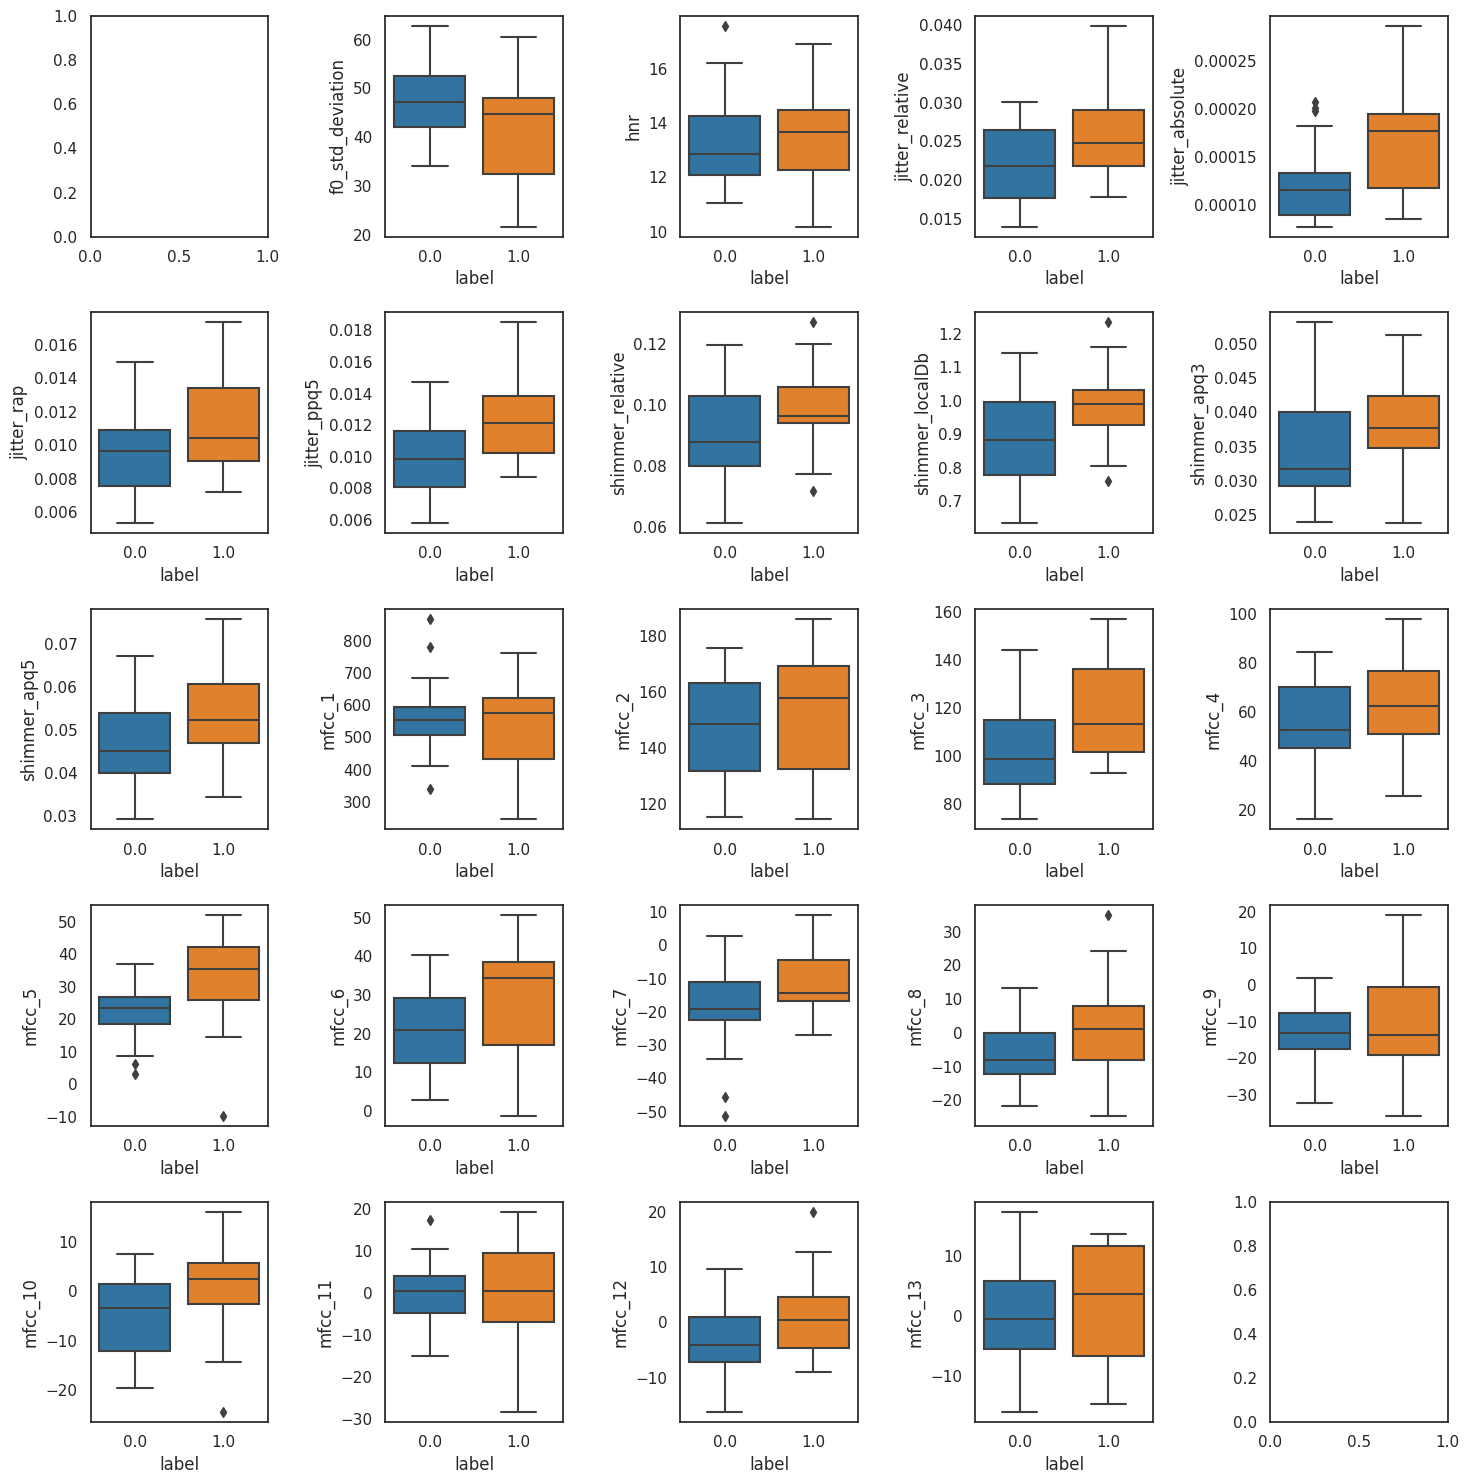

In [ ]:
#Box Plot after adjust outliers..
fig,axes=plt.subplots(5,5,figsize=(15,15))
axes=axes.flatten()

for i in range(1,len(df.columns)-1):
    sns.boxplot(x='label',y=df.iloc[:,i],data=df,orient='v',ax=axes[i])
plt.tight_layout()
plt.show()

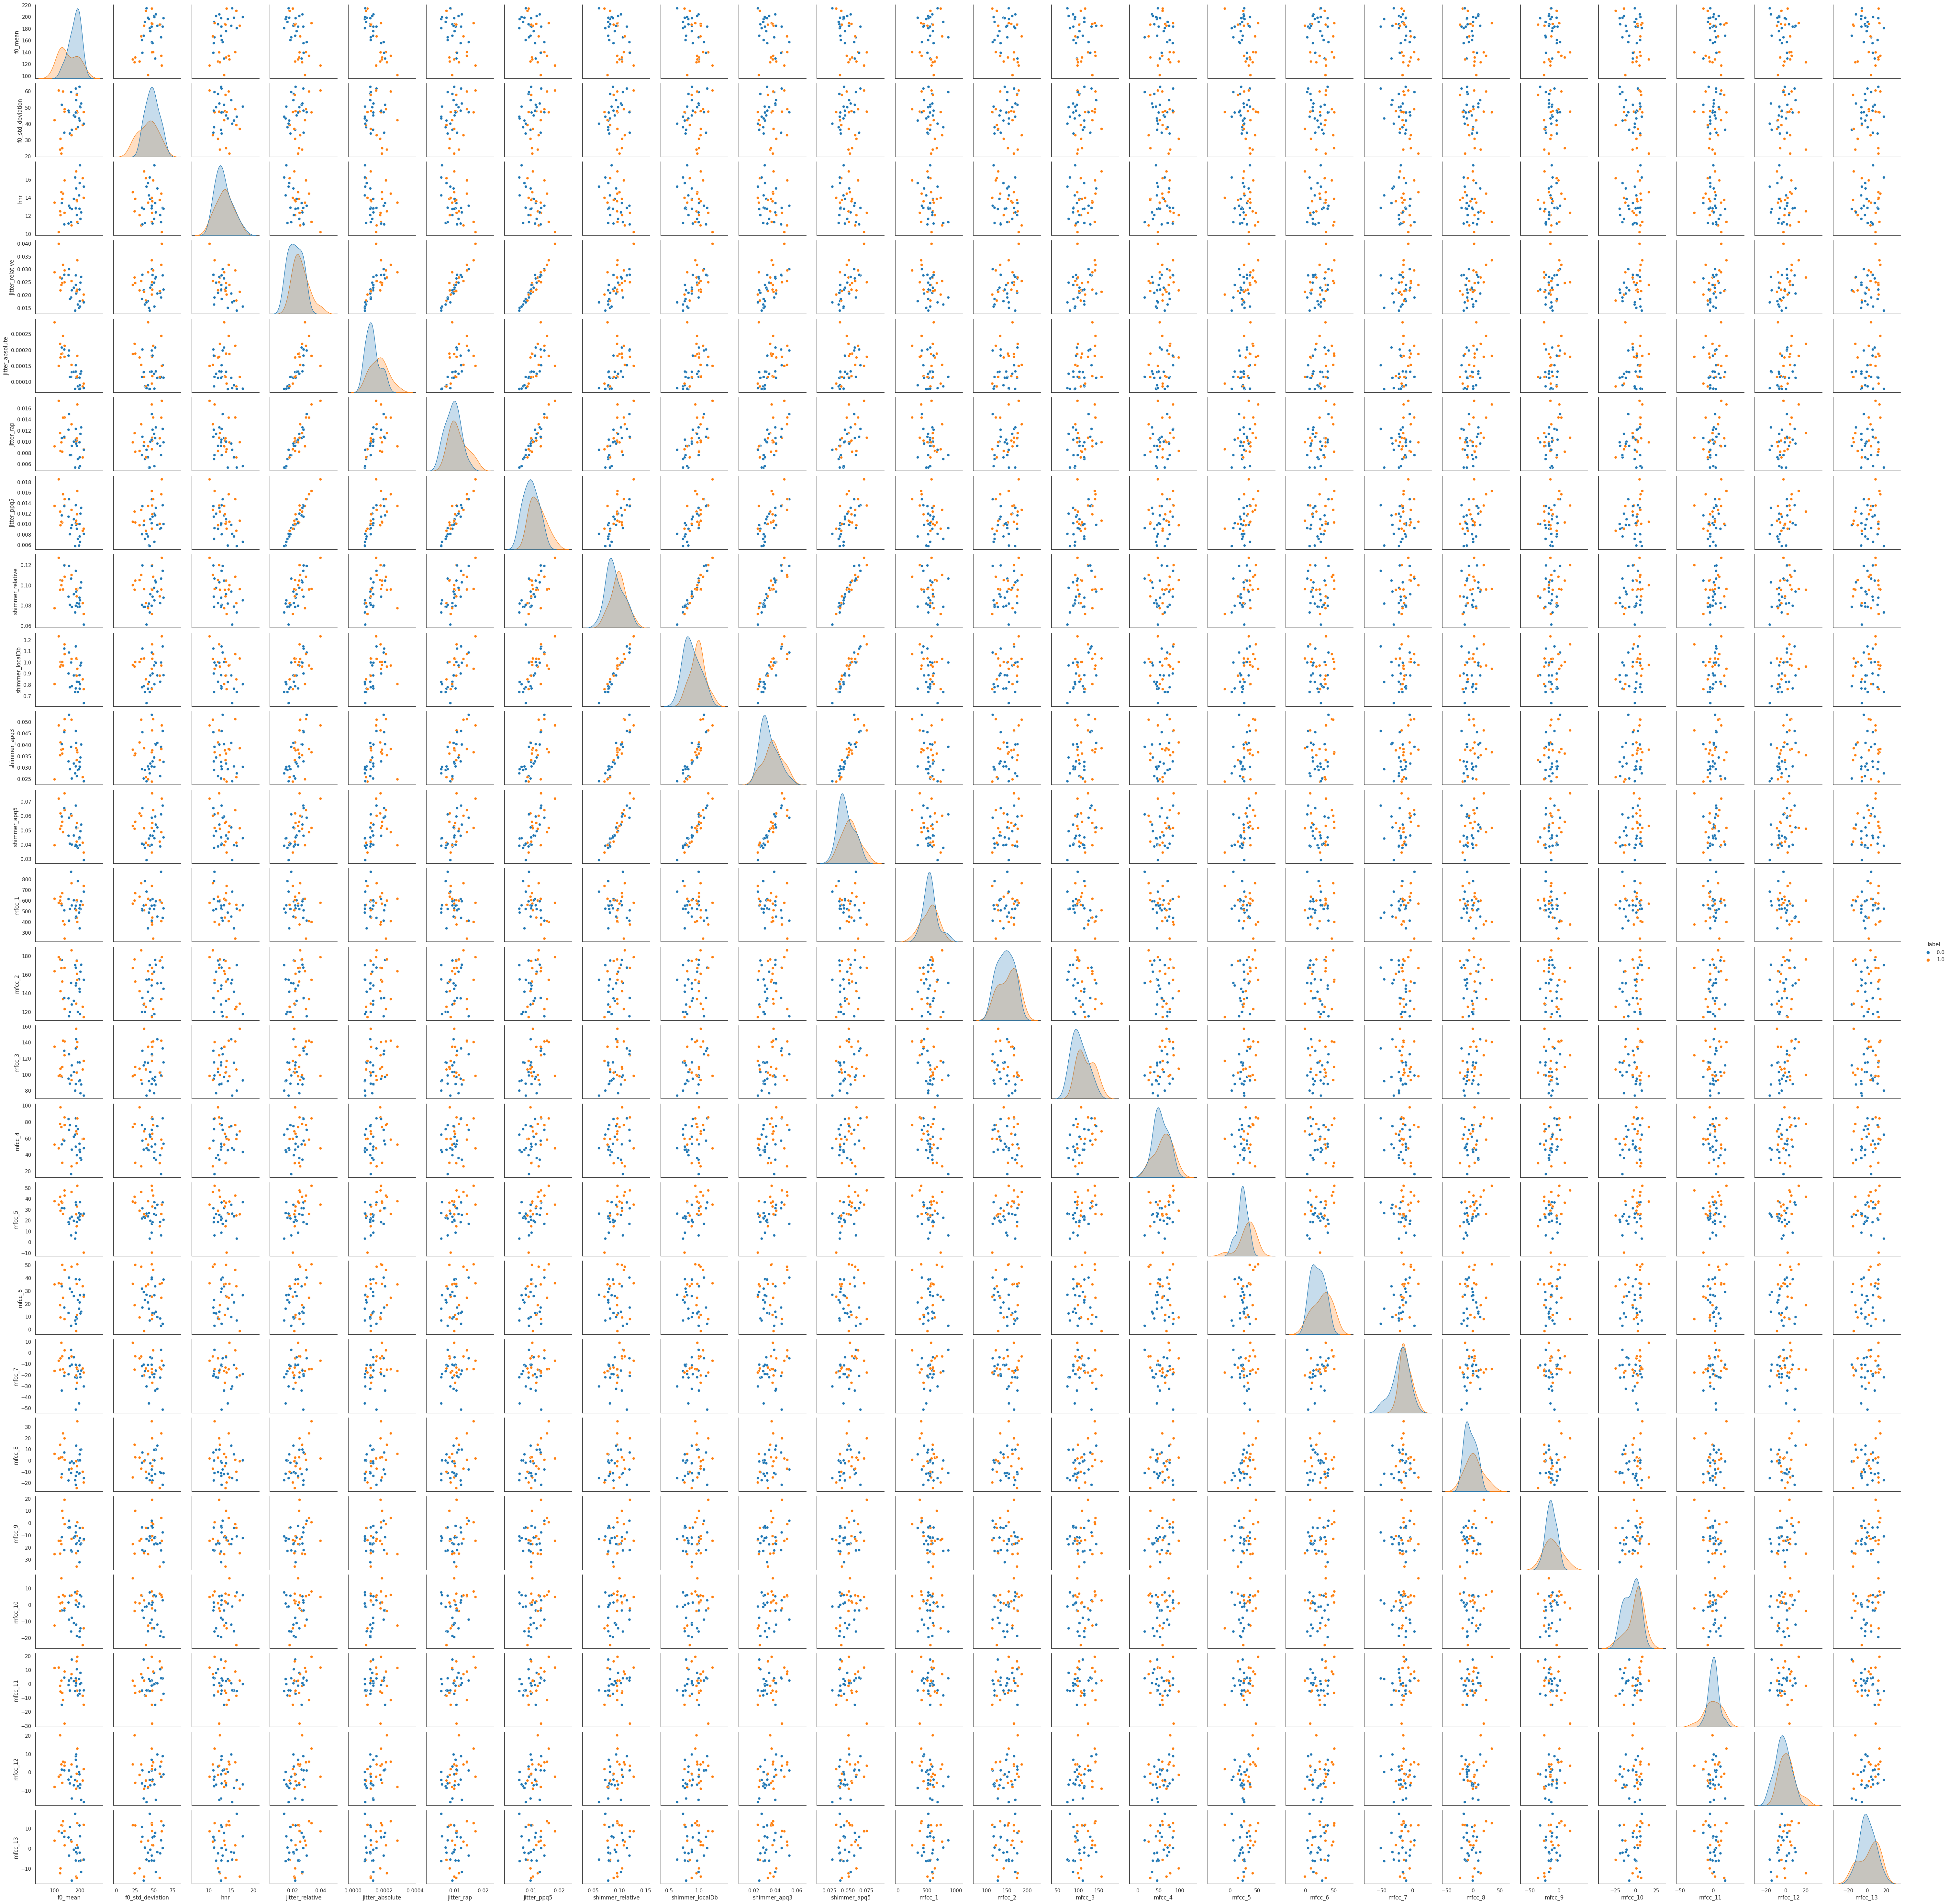

In [ ]:
#show the features distribution..
plt.rcParams['figure.figsize'] = (15, 4)
sns.pairplot(df,hue = 'label')
plt.show()

In [ ]:
# Convert DataFrame to CSV and save to Google Drive
'''
EXT_data = '/content/drive/MyDrive/Project-code-2023/EXP-wav/data/EXT_data.csv'
df.to_csv(EXT_data, index=False)

# Print success message
print('CSV file saved to Google Drive.')
'''

CSV file saved to Google Drive.


In [ ]:
X = dff.drop(columns='label')
y = pd.DataFrame(dff['label'])

print(f'X shape : {X.shape}')
print(f'y shape : {y.shape}')

X shape : (37, 24)
y shape : (37, 1)


In [ ]:
#solve imbalancing issue ..

from imblearn.over_sampling import SMOTENC

smotenc = SMOTENC(categorical_features=[0, 2, 4, 6, 8, 10, 12, 14], random_state=0)
X_resampled, y_resampled = smotenc.fit_resample(X, y)

print(f"Before oversampling: {X.shape}, {y.shape}")
print(f"After oversampling: {X_resampled.shape}, {y_resampled.shape}")

Before oversampling: (37, 24), (37, 1)
After oversampling: (42, 24), (42, 1)


In [ ]:
y_resampled.value_counts()

label
0.0      21
1.0      21
dtype: int64

In [ ]:
#split the dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify= y, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (27, 24)
X_test shape: (10, 24)
y_train shape: (27, 1)
y_test shape: (10, 1)


In [ ]:
### store the preprocessed data for use in the next notebook
'''
%store X_train 
%store X_test 
%store y_train 
%store y_test 
'''

In [ ]:
#scale the datset..

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# **BaseLine model**

In [ ]:
def baseline(X):
  y_pred = []
  for i in range(len(X)):
    y_pred.append(1)
  return y_pred 

In [ ]:
def confusion_matrix(y_test, y_pred):
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = [0, 1],
                  columns = [0, 1])
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
y_pred = baseline(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.40      1.00      0.57         4

    accuracy                           0.40        10
   macro avg       0.20      0.50      0.29        10
weighted avg       0.16      0.40      0.23        10



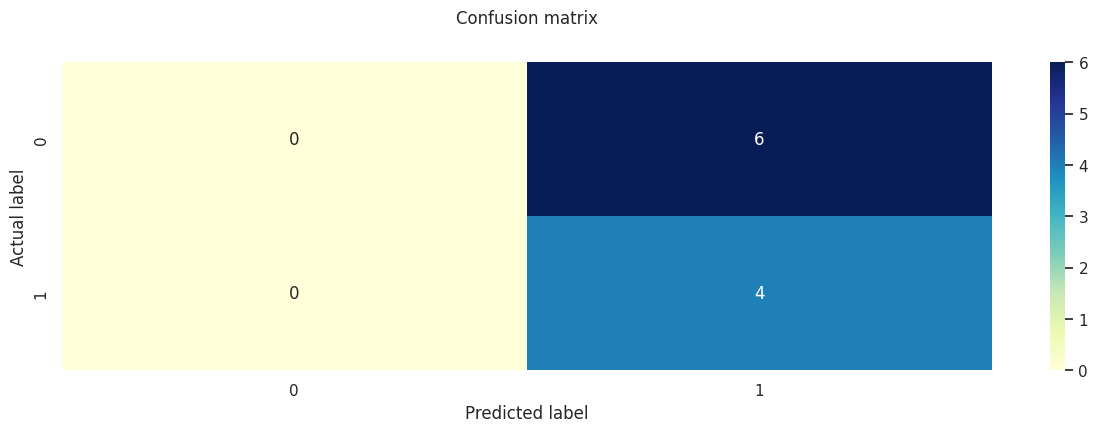

In [ ]:
confusion_matrix(y_test, y_pred)

# **Descision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
predDT = clf.predict(X_test)

print(classification_report(y_test, predDT))

              precision    recall  f1-score   support

         0.0       0.60      0.50      0.55         6
         1.0       0.40      0.50      0.44         4

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.52      0.50      0.51        10



In [ ]:
param_grid = { 
    'max_depth' :range(1,10),
    'random_state':range(30,210,30),
    'criterion' :['gini', 'entropy']
}
CV_dt = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 10)
CV_dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'random_state': range(30, 210, 30)})

In [ ]:
CV_dt.best_params_

{'criterion': 'gini', 'max_depth': 3, 'random_state': 120}

In [ ]:
dt1=DecisionTreeClassifier(random_state=120, max_depth=3, criterion='gini')
dt1.fit(X_train, y_train)
predDT = dt1.predict(X_test) 
print(classification_report(y_test, predDT))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         6
         1.0       0.50      0.50      0.50         4

    accuracy                           0.60        10
   macro avg       0.58      0.58      0.58        10
weighted avg       0.60      0.60      0.60        10



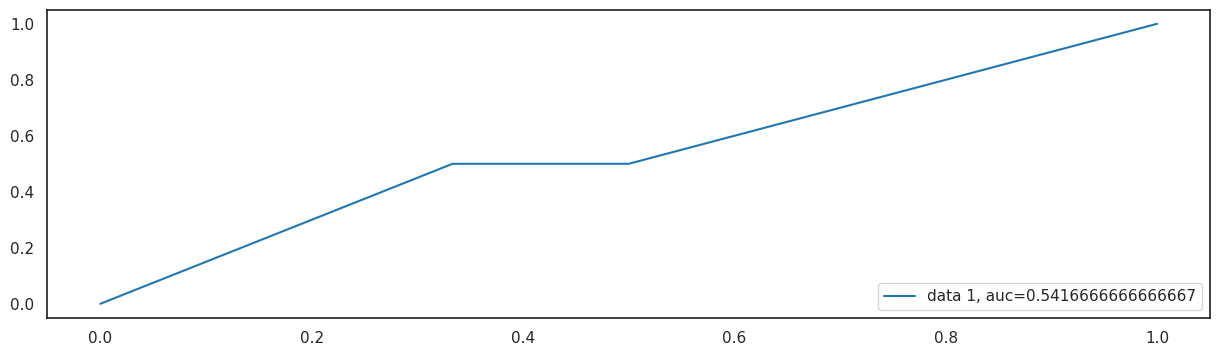

In [ ]:
y_pred_proba = dt1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

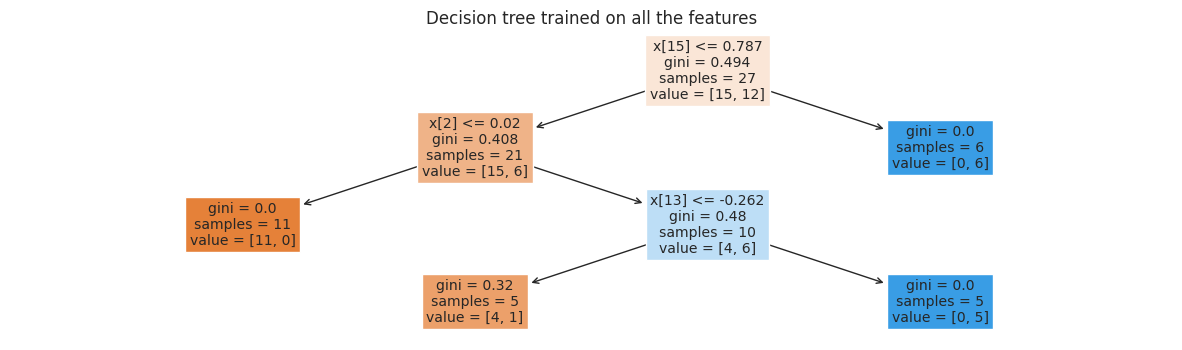

In [ ]:
from sklearn.tree import plot_tree

plt.figure()
plot_tree(dt1, filled=True)
plt.title("Decision tree trained on all the features")
plt.show()

# **Random Forest**

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predRF = rfc.predict(X_test)

print(classification_report(y_test, predRF))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83         6
         1.0       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79      0.79        10
weighted avg       0.80      0.80      0.80        10



In [ ]:
param_grid = { 
    'n_estimators': range(100,300,25),
    'max_depth' :range(1,10),
    'random_state':range(100,250,50),
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'n_estimators': range(100, 300, 25),
                         'random_state': range(100, 250, 50)})

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100, 'random_state': 150}

In [ ]:
rfc1=RandomForestClassifier(random_state=150, n_estimators= 100, max_depth=3, criterion='gini')
rfc1.fit(X_train, y_train)
predRFC = rfc1.predict(X_test)
print(classification_report(y_test, predRFC))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



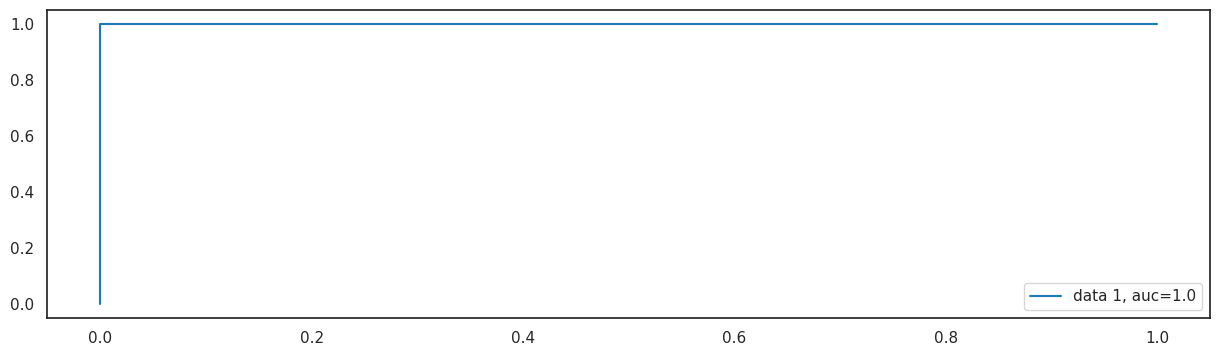

In [ ]:
y_pred_proba = rfc1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# **SVM**

In [ ]:
grid_SVC = svm.SVC(C = 100, gamma = 1, kernel = 'linear')
grid_SVC.fit(X_train, y_train)

predSVC = grid_SVC.predict(X_test) 
  
# print classification report 
print("\n", classification_report(y_test, predSVC))


               precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         6
         1.0       0.25      0.25      0.25         4

    accuracy                           0.40        10
   macro avg       0.38      0.38      0.38        10
weighted avg       0.40      0.40      0.40        10



In [ ]:
param_grid = {'kernel':['linear','rbf','poly'],'C': [0.5, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid_SVC = GridSearchCV(svm.SVC(), param_grid, scoring='f1',cv= 10, verbose = 3)
grid_SVC.fit(X_train, y_train)

# print best parameter after tuning 
print("\nBest Parameters: ", grid_SVC.best_params_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10] END ....C=0.5, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 2/10] END ....C=0.5, gamma=1, kernel=linear;, score=0.000 total time=   0.0s
[CV 3/10] END ....C=0.5, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 4/10] END ....C=0.5, gamma=1, kernel=linear;, score=0.500 total time=   0.0s
[CV 5/10] END ....C=0.5, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 6/10] END ....C=0.5, gamma=1, kernel=linear;, score=0.000 total time=   0.0s
[CV 7/10] END ....C=0.5, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 8/10] END ....C=0.5, gamma=1, kernel=linear;, score=0.000 total time=   0.0s
[CV 9/10] END ....C=0.5, gamma=1, kernel=linear;, score=0.000 total time=   0.0s
[CV 10/10] END ...C=0.5, gamma=1, kernel=linear;, score=0.000 total time=   0.0s
[CV 1/10] END .......C=0.5, gamma=1, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/10] END .......C=0.5, gamma=1, kernel=rb

In [ ]:
# print how our model looks after hyper-parameter tuning
print("\n", grid_SVC.best_estimator_)

predSVC = grid_SVC.predict(X_test) 
  
# print classification report 
print("\n", classification_report(y_test, predSVC))


 SVC(C=10, gamma=0.01)

               precision    recall  f1-score   support

         0.0       0.71      0.83      0.77         6
         1.0       0.67      0.50      0.57         4

    accuracy                           0.70        10
   macro avg       0.69      0.67      0.67        10
weighted avg       0.70      0.70      0.69        10



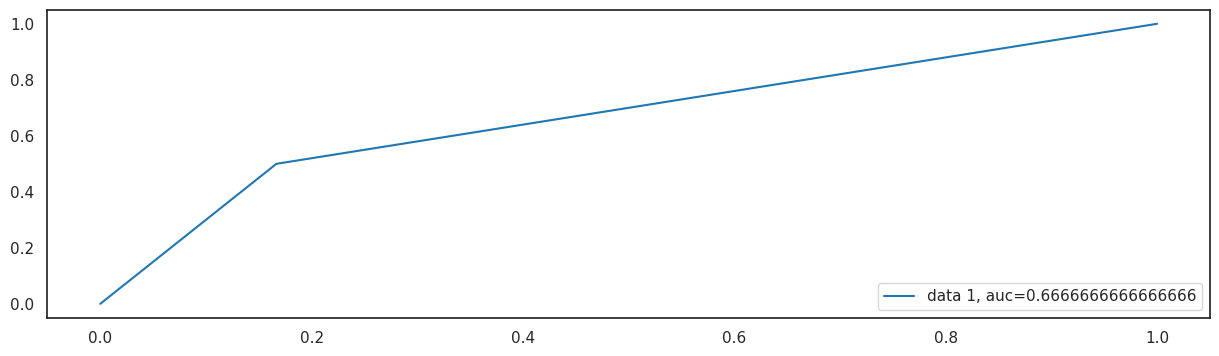

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  predSVC)
auc = metrics.roc_auc_score(y_test, predSVC)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# **Extreme Learning Machine**

In [ ]:
input_size = X_train.shape[1]
hidden_neurons = 7000

Win = np.random.normal(size=[input_size, hidden_neurons])
biases = np.random.normal(size=[hidden_neurons])

In [ ]:
def hidden_output(x, Win):
  """caculate output of hidden layer"""
  a = np.dot(x, Win)
  a = a + biases
  a = np.maximum(a, 0, a) # ReLUr
  return a

def W_hidden_output(x, y, Win):
  """calculate weight between hidden layer and output"""
  H = hidden_output(x, Win)
  Ht = np.transpose(H)
  Wout = np.dot(np.linalg.inv(np.dot(Ht, H)), np.dot(Ht, y))
  return Wout

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def predict(x, Win, Wout):
  H = hidden_output(x, Win)
  y_pred = np.dot(H, Wout)
  y_pred = sigmoid(y_pred)
  y_pred = np.round(y_pred)
  return y_pred

In [ ]:
input_size = X_train.shape[1]
hidden_neurons = 7000

Win = np.random.normal(size=[input_size, hidden_neurons])
biases = np.random.normal(size=[hidden_neurons])
print(f'biases for hidden layer shape : {biases.shape}')
print(f'weight from input to hidden shape : {Win.shape}')
print(f'10 first element of the first row of Win : \n {Win[0][:10]}')

biases for hidden layer shape : (7000,)
weight from input to hidden shape : (24, 7000)
10 first element of the first row of Win : 
 [-1.062528    0.31653607 -0.33981566  0.8791691  -0.60543972 -0.88823592
  3.11581497 -0.54468895 -1.07820168  0.45587186]


In [ ]:
import tqdm
cv_scores = {'Accuracy': []}
fold = StratifiedKFold(10)

X, y = X_train, y_train

for train_index, valid_index in tqdm.tqdm(fold.split(X, y)):
    x_train_, x_valid = X[train_index], X[valid_index]
    y_train_, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    Wout = W_hidden_output(x_train_, y_train_, Win)
    y_pred_valid = predict(x_valid, Win, Wout)
    cv_scores['Accuracy'].append(accuracy_score(y_valid, y_pred_valid))

mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}      
print(f"ELM accuracy : {mean_cv_scores['Accuracy']}")

10it [05:44, 34.41s/it]

ELM accuracy : 0.31666666666666665


In [ ]:
Wout = W_hidden_output(X_train, y_train, Win)
y_pred_train = predict(X_train, Win, Wout)
y_pred_test = predict(X_test, Win, Wout)

In [ ]:
print(f'elm accuracy on train set: {accuracy_score(y_train, y_pred_train)}')
print(f'elm accuracy on test set : {accuracy_score(y_test, y_pred_test)}')

elm accuracy on train set: 0.4444444444444444
elm accuracy on test set : 0.7


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         6
         1.0       0.57      1.00      0.73         4

    accuracy                           0.70        10
   macro avg       0.79      0.75      0.70        10
weighted avg       0.83      0.70      0.69        10



In [ ]:
from sklearn.metrics import precision_score,recall_score ,accuracy_score, f1_score, r2_score, log_loss

chart = {
        'Metric':["Accuracy", "F1-Score", "Recall", "Precision", "R2-Score"],
        'DT':[accuracy_score(y_test, predDT), f1_score(y_test, predDT), recall_score(y_test, predDT), precision_score(y_test, predDT), r2_score(y_test, predDT)],
        'RF':[accuracy_score(y_test, predRF), f1_score(y_test, predRFC), recall_score(y_test, predRFC), precision_score(y_test, predRFC), r2_score(y_test, predRFC)],
        'SVM':[accuracy_score(y_test, predSVC), f1_score(y_test, predSVC), recall_score(y_test, predSVC), precision_score(y_test, predSVC), r2_score(y_test, predSVC)],
        'ELM':[accuracy_score(y_test, y_pred_test), f1_score(y_test, y_pred_test), recall_score(y_test, y_pred_test), precision_score(y_test, y_pred_test), r2_score(y_test, y_pred_test)],
}
chart = pd.DataFrame(chart)
display(chart)

Metric        DT   RF       SVM       ELM
0   Accuracy  0.600000  0.8  0.700000  0.700000
1   F1-Score  0.500000  1.0  0.571429  0.727273
2     Recall  0.500000  1.0  0.500000  1.000000
3  Precision  0.500000  1.0  0.666667  0.571429
4   R2-Score -0.666667  1.0 -0.250000 -0.250000